# 22.02.03.

In [215]:
import sys

full_path_to_modul_dir = 'D:\mcbj_stmbj'  # here enter the full path to the directory that contains the modul on your computer
sys.path.append(full_path_to_modul_dir)

import re
import os
import warnings
warnings.filterwarnings("error")

<>:3: DeprecationWarning: invalid escape sequence \m
<>:3: DeprecationWarning: invalid escape sequence \m
C:\Users\Admin\AppData\Local\Temp\ipykernel_11680\1357785428.py:3: DeprecationWarning: invalid escape sequence \m
  full_path_to_modul_dir = 'D:\mcbj_stmbj'  # here enter the full path to the directory that contains the modul on your computer


In [216]:
from mcbj import *
import filter_traces
import plots
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

date = "22_02_03"
sample_rate = 50_000
home_folder = Path(f"D:/BJ_Data/{date}")
# home_folder = Path(f"//DATACENTER/BreakJunction_group/BJ_Data/{date}")

In [217]:
# rcParams['figure.constrained_layout.use'] = False
# rcParams['font.family'] = 'serif'
# rcParams['font.serif'] = ['Times New Roman']
# rcParams['mathtext.fontset'] = 'stix'
# rcParams['mathtext.rm'] = 'serif'
# rcParams['xtick.direction'] = 'in'
# rcParams['ytick.direction'] = 'in'
# rcParams['xtick.labelsize'] = 10
# rcParams['ytick.labelsize'] = 10
# rcParams['xtick.major.pad'] = 4
# rcParams['xtick.minor.pad'] = 0.5
# rcParams['ytick.major.pad'] = 2
# rcParams['ytick.minor.pad'] = 0.5
# rcParams['axes.labelsize'] = 10
# rcParams['axes.titlepad'] = 8.0
# rcParams['axes.labelpad'] = 2.0
# rcParams['agg.path.chunksize'] = 10000

In [218]:
# rcParams['font.size'] = 14
# rcParams['ytick.labelsize'] = 10
# rcParams['xtick.labelsize'] = 10
# rcParams['axes.labelsize'] = 10

In [219]:
def calc_noise_sim(sim_data_df, dgap=0.0, dphi=0.0):
    """
    Calculates noise from simulation data.
    You can select which parameter you want to be fluctuating and set the other to zero.
    If both values are nonzero, both parameters fluctuate.
    
    Parameters
    ----------
    sim_data_df: `pd.DataFrame` containing data from Laci's simulation software. (best fit parameters)
    dgap: float, gap fluctuation in nm, default: 0.0
    dphi: float, barrier fluctuation in eV, default: 0.0
        
    Returns
    -------
    calculated relative noise (dG/G) with the given fluctuating variables (dgap, dphi).
    """
    
    # 1e-9
    # 1.6e-19
    
    # if dgap is None and dphi is None:
    #     raise ValueError(f'You entered dgap={dgap} and dphi={dphi}. One of them has to be not `None`')
    # elif dgap is None:
    #     print("Calculating relative noise when the barrier fluctuates.")
    #     sim_fluct_relnoise_push = sim_data_df['dR/dPhi'] * dphi * 1.6e-19 / sim_data_df['R [Ohm]']
    # elif dphi is None:
    #     print("Calculating relative noise when the gap fluctuates.")
    #     sim_fluct_relnoise_push = sim_data_df['dR/dz'] * dgap * 1e-9 / sim_data_df['R [Ohm]']
    # else:
    #     print("Calculating relative noise when both the barrier and the gap fluctuates.")
    #     sim_fluct_relnoise_push = np.sqrt((sim_data_df['dR/dz'] * dgap * 1e-9)**2 + (sim_data_df['dR/dPhi'] * dphi * 1.6e-19)**2) / sim_data_df['R [Ohm]']
    #    
    # return sim_fluct_relnoise_push
    
    print(f"Calculating relative noise when the barrier fluctuation is dphi={dphi} eV and the gap fluctuation is dgap={dgap} nm.")
    
    return np.sqrt((sim_data_df['dR/dz'] * dgap * 1e-9)**2 + (sim_data_df['dR/dPhi'] * dphi * 1.6e-19)**2) / sim_data_df['R [Ohm]']

In [220]:
def calc_2D_rel_noise_hists(df: pd.DataFrame, x_vars: Tuple[str, ...], y_vars: Tuple[str, ...],                            
                            xrange=(1e-5, 10), yrange=(1e-2, 1), xbins_num=100, ybins_num=100,
                            log_scale=True, bin_mode='total'):
   
    x_bins_all = []
    y_bins_all = []
    x_hist1d_all = []
    y_hist1d_all = []
    x_mesh_all = []
    y_mesh_all = []
    hist2d_all = []
    
    for i in range(len(x_vars)):        
        x_bins, x_hist1d = utils.calc_hist_1d_single(data=df[x_vars[i]], xrange=xrange,
                                                     xbins_num=xbins_num, log_scale=log_scale, bin_mode=bin_mode)
        y_bins, y_hist1d = utils.calc_hist_1d_single(data=df[y_vars[i]], xrange=yrange,
                                                     xbins_num=ybins_num, log_scale=log_scale, bin_mode=bin_mode)

        h, xedges, yedges = np.histogram2d(df[x_vars[i]], df[y_vars[i]],
                                           bins=[x_bins, y_bins])
        x_mesh, y_mesh = np.meshgrid(xedges, yedges)
        
        x_bins_all.append(x_bins)
        y_bins_all.append(y_bins)
        x_hist1d_all.append(x_hist1d)
        y_hist1d_all.append(y_hist1d)
        hist2d_all.append(h.T)
        x_mesh_all.append(x_mesh)
        y_mesh_all.append(y_mesh)
        
    return x_bins_all, x_hist1d_all, y_bins_all, y_hist1d_all, hist2d_all, x_mesh_all, y_mesh_all
    

def plot_2D_rel_noise_hists(df: pd.DataFrame, x_vars: Tuple[str, ...], y_vars: Tuple[str, ...],                            
                            xrange=(1e-5, 10), yrange=(1e-2, 1), xbins_num=100, ybins_num=100,
                            log_scale=True, bin_mode='total', figsize=utils.cm2inch(16, 5), dpi=600,
                            cmap='viridis', **kwargs):
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = plt.GridSpec(1, len(x_vars), figure=fig,
                      left=0.08, right=0.92, top=0.9, bottom=0.13,
                      hspace=0.0, wspace=0.0)
    ax = []
    
    xbins_all, x_hist1d_all, ybins_all, y_hist1d_all, hist2d_all, x_mesh_all, y_mesh_all =\
        calc_2D_rel_noise_hists(df=df,
                                x_vars=x_vars, y_vars=y_vars,
                                xrange=xrange, yrange=yrange,
                                xbins_num=xbins_num, ybins_num=ybins_num, log_scale=log_scale, bin_mode=bin_mode)
    
    for i in range(len(x_vars)):
        ax.append(fig.add_subplot(gs[i]))
        im_pull = ax[i].pcolormesh(x_mesh_all[i], y_mesh_all[i], hist2d_all[i], cmap=cmap, **kwargs)
        
        ax[i].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                          labelleft=False, labelright=False, labeltop=False, labelbottom=True)
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].set_xlabel(x_vars[i])
        ax[i].set_ylabel(y_vars[i])
        
    ax[0].tick_params(which='both',
                      labelleft=True, labelright=False, labeltop=False, labelbottom=True)
    ax[-1].tick_params(which='both',
                      labelleft=False, labelright=True, labeltop=False, labelbottom=True)
    
    return fig, ax
    
def plot_2D_rel_noise_hist_and_scatter(df: pd.DataFrame,
                                       x_2d_vars: Tuple[str, ...], y_2d_vars: Tuple[str, ...],
                                       x_scat_vars: Tuple[str, ...], y_scat_vars: Tuple[str, ...],
                                       xrange=(1e-5, 10), yrange=(1e-2, 1), xbins_num=100, ybins_num=100,
                                       log_scale=True, bin_mode='total', cmap='viridis',
                                       figsize=utils.cm2inch(16, 10), dpi=600, **kwargs):
    
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = plt.GridSpec(1, len(x_2d_vars), figure=fig,
                      left=0.08, right=0.92, top=0.9, bottom=0.13,
                      hspace=0.0, wspace=0.0)
    ax = []
    
    xbins_all, x_hist1d_all, ybins_all, y_hist1d_all, hist2d_all, x_mesh_all, y_mesh_all =\
        calc_2D_rel_noise_hists(df=df,
                                x_vars=x_2d_vars, y_vars=y_2d_vars,
                                xrange=xrange, yrange=yrange,
                                xbins_num=xbins_num, ybins_num=ybins_num, log_scale=log_scale, bin_mode=bin_mode)
    
    for i in range(len(x_2d_vars)):
        ax.append(fig.add_subplot(gs[i]))
        im_pull = ax[i].pcolormesh(x_mesh_all[i], y_mesh_all[i], hist2d_all[i], cmap=cmap)
        
        for j in range(len(x_scat_vars)):
            ax[i].scatter(df[x_scat_vars[j]], df[y_scat_vars[j]], **kwargs)
        
        ax[i].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                          labelleft=False, labelright=False, labeltop=False, labelbottom=False)
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].set_xlabel(x_2d_vars[i])
        ax[i].set_ylabel(x_2d_vars[i])
        
    return fig, ax

## Hold OFF

In [3]:
hold_off_traces = [np.arange(301, 3133, 1),
                   np.arange(3133, 16101, 1),
                   np.arange(16101, 19501, 1),
                   np.arange(25801, 26901, 1),
                   np.arange(29001, 30501, 1),
                   np.arange(32201, 33601, 1),
                   np.arange(38201, 40101, 1),
                   np.arange(43301, 49101, 1),
                   np.arange(49101, 61500, 1)]

In [4]:
hold_off_hists = []

for traces in hold_off_traces:
    hold_off_hists.append(Histogram(folder=home_folder,
                                    traces=traces,
                                    conductance_range=(1e-5, 10),
                                    conductance_bins_num=20,
                                    conductance_bins_mode='decade'))
    hold_off_hists[-1].calc_stats(align_at=0.1,
                                  range_pull=(-0.05, 0.2),
                                  range_push=(-0.5, 1.2))

  0%|          | 0/2832 [00:00<?, ?it/s]

Pull 2D histogram created from 2831 traces
Push 2D histogram created from 2831 traces


  0%|          | 0/12968 [00:00<?, ?it/s]

Pull 2D histogram created from 12968 traces
Push 2D histogram created from 12968 traces


  0%|          | 0/3400 [00:00<?, ?it/s]

Pull 2D histogram created from 3400 traces
Push 2D histogram created from 3400 traces


  0%|          | 0/1100 [00:00<?, ?it/s]

Pull 2D histogram created from 1100 traces
Push 2D histogram created from 1100 traces


  0%|          | 0/1500 [00:00<?, ?it/s]

Pull 2D histogram created from 1500 traces
Push 2D histogram created from 1500 traces


  0%|          | 0/1400 [00:00<?, ?it/s]

Pull 2D histogram created from 1400 traces
Push 2D histogram created from 1400 traces


  0%|          | 0/1900 [00:00<?, ?it/s]

Pull 2D histogram created from 1900 traces
Push 2D histogram created from 1900 traces


  0%|          | 0/5800 [00:00<?, ?it/s]

Pull 2D histogram created from 5800 traces
Push 2D histogram created from 5800 traces


  0%|          | 0/12399 [00:00<?, ?it/s]

Pull 2D histogram created from 12399 traces
Push 2D histogram created from 12399 traces


9


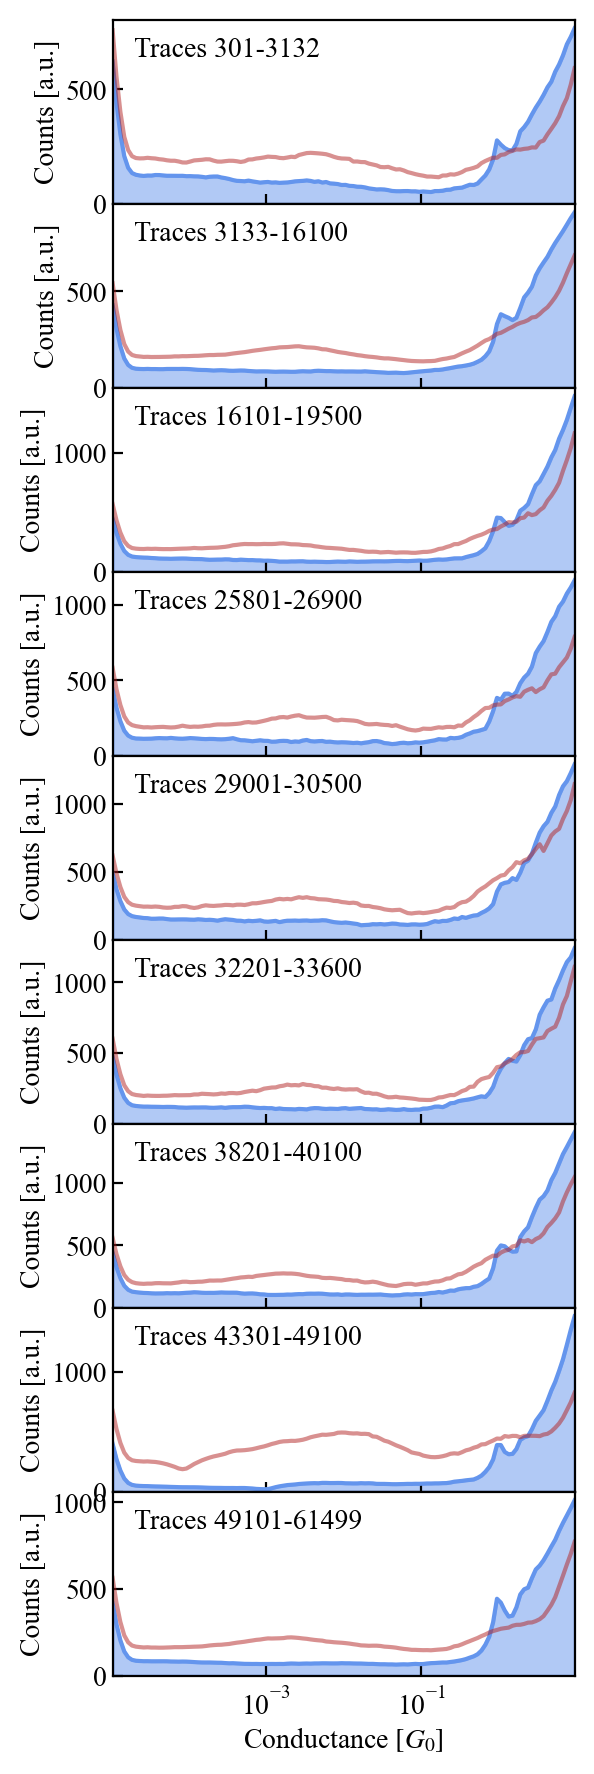

In [128]:
print(len(hold_off_hists))
figsize=(3, 1*len(hold_off_hists))
dpi=200
fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(len(hold_off_hists), 1, figure=fig,
                  left=0.19, right=0.96, top=0.98, bottom=0.06,
                  hspace=0, wspace=0.2)

ax_hists = []
for i, hist in enumerate(hold_off_hists):
    ax_hists.append(fig.add_subplot(gs[i]))
    
    hist.plot_hist_1d(ax=ax_hists[i], dpi=dpi)
    ax_hists[i].text(x=2e-5, y=0.8*ax_hists[i].get_ylim()[1], s=f'Traces {hold_off_traces[i][0]}-{hold_off_traces[i][-1]}', fontsize=10)
    ax_hists[i].set_ylabel('Counts [a.u.]')
    
plt.savefig(home_folder.joinpath('results/histograms_1D_hold_off.png'))

## Hold ON traces

In [65]:
trace_pair =TracePair(19502, load_from=home_folder)

r_serial = trace_pair.R_serial
print(r_serial)

100000.0


In [27]:
hold_on_traces = [np.arange(19502, 25701, 1),
                  np.arange(26901, 29001, 1),
                  np.arange(30501, 32201, 1),
                  np.arange(33601, 38201, 1),
                  np.arange(40101, 43301, 1),
                  np.arange(44301, 49101, 1)]

In [28]:
hold_on_hists = []

for traces in hold_on_traces:
    hold_on_hists.append(Histogram(folder=home_folder,
                                   traces=traces,
                                   conductance_range=(1e-5, 10),
                                   conductance_bins_num=20,
                                   conductance_bins_mode='decade'))
    hold_on_hists[-1].calc_stats(align_at=0.1,
                                 range_pull=(-0.05, 0.2),
                                 range_push=(-0.5, 1.2))

  0%|          | 0/6199 [00:00<?, ?it/s]

Pull 2D histogram created from 6199 traces
Push 2D histogram created from 6199 traces


  0%|          | 0/2100 [00:00<?, ?it/s]

Pull 2D histogram created from 2100 traces
Push 2D histogram created from 2100 traces


  0%|          | 0/1700 [00:00<?, ?it/s]

Pull 2D histogram created from 1700 traces
Push 2D histogram created from 1700 traces


  0%|          | 0/4600 [00:00<?, ?it/s]

Pull 2D histogram created from 4600 traces
Push 2D histogram created from 4600 traces


  0%|          | 0/3200 [00:00<?, ?it/s]

Pull 2D histogram created from 3200 traces
Push 2D histogram created from 3200 traces


  0%|          | 0/4800 [00:00<?, ?it/s]

Pull 2D histogram created from 4800 traces
Push 2D histogram created from 4800 traces


6


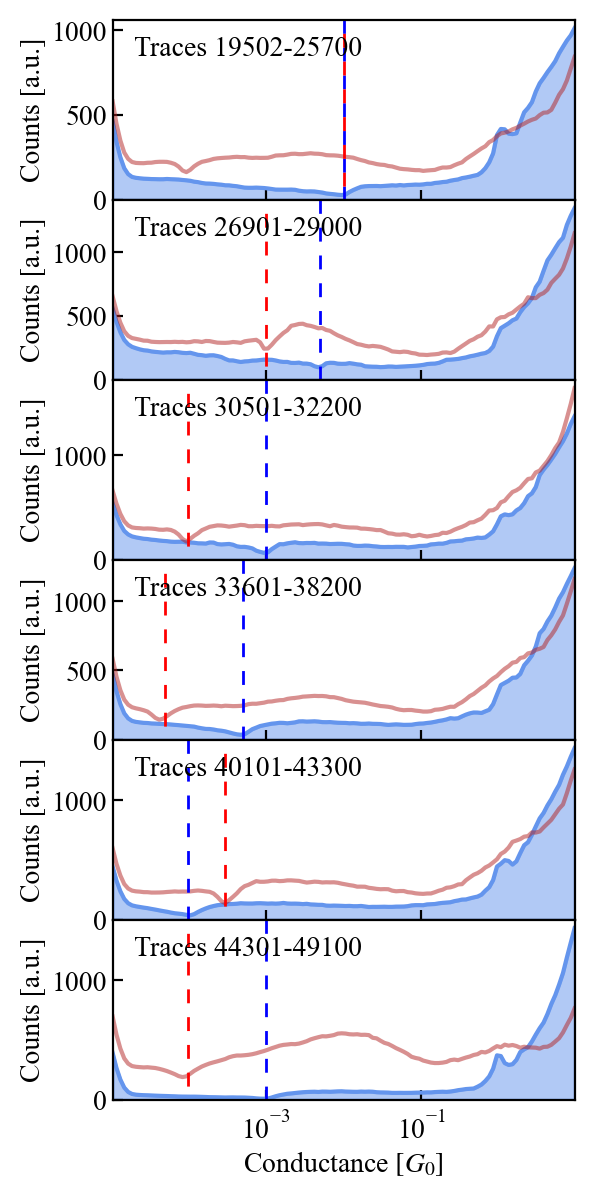

In [125]:
print(len(hold_on_hists))
figsize=(3, 1*len(hold_on_hists))
dpi=200
fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(len(hold_on_hists), 1, figure=fig,
                  left=0.19, right=0.96, top=0.98, bottom=0.08,
                  hspace=0, wspace=0.2)

ax_hists = []
for i, hist in enumerate(hold_on_hists):
    ax_hists.append(fig.add_subplot(gs[i]))
    trace_pair = TracePair(hist.traces[-1], load_from=home_folder)
    
    hist.plot_hist_1d(ax=ax_hists[i], dpi=dpi)
    ax_hists[i].text(x=2e-5, y=0.8*ax_hists[i].get_ylim()[1], s=f'Traces {hold_on_traces[i][0]}-{hold_on_traces[i][-1]}', fontsize=10)
    ax_hists[i].set_ylabel('Counts [a.u.]')
    ax_hists[i].axvline(trace_pair.hold_set_pull, c='b', ls=(0, (5, 5)), lw=1)
    ax_hists[i].axvline(trace_pair.hold_set_push, c='r', ls=(5, (5, 5)), lw=1)
    
plt.savefig(home_folder.joinpath('results/histograms_1D_hold_on.png'))

In [62]:
hold_on_traces_total = np.concatenate(hold_on_traces)

In [79]:
total_num = hold_on_traces_total.shape[0]

In [63]:
warnings.filterwarnings("error")

In [67]:
pull_set_trigger = np.zeros_like(hold_on_traces_total)*np.nan
pull_last_before_hold = np.zeros_like(hold_on_traces_total)*np.nan
pull_first_after_hold = np.zeros_like(hold_on_traces_total)*np.nan
pull_start_avg = np.zeros_like(hold_on_traces_total)*np.nan
pull_end_avg = np.zeros_like(hold_on_traces_total)*np.nan
iv_diff_pull = np.zeros_like(hold_on_traces_total)*np.nan

push_set_trigger = np.zeros_like(hold_on_traces_total)*np.nan
push_last_before_hold = np.zeros_like(hold_on_traces_total)*np.nan
push_first_after_hold = np.zeros_like(hold_on_traces_total)*np.nan
push_start_avg = np.zeros_like(hold_on_traces_total)*np.nan
push_end_avg = np.zeros_like(hold_on_traces_total)*np.nan
iv_diff_push = np.zeros_like(hold_on_traces_total)*np.nan

for i, trace in enumerate(tqdm(hold_on_traces_total)):
    trace_pair = TracePair(trace, load_from=home_folder)
    
    try:
        hold_trace= HoldTrace(trace,
                              load_from=home_folder, bias_offset=0,
                              r_serial_ohm=r_serial, min_step_len=20_000, min_height=1, iv=0)

        pull_set_trigger[i] = trace_pair.hold_set_pull
        pull_last_before_hold[i] = trace_pair.conductance_pull[trace_pair.hold_index_pull]
        pull_first_after_hold[i] = trace_pair.conductance_pull[trace_pair.hold_index_pull + 1]
        pull_start_avg[i] = hold_trace.G_hold_pull
        pull_end_avg[i] = hold_trace.G_avg_pull
        iv_diff_pull[i] = filter_traces.iv_difference(hold_trace, direction='pull', smoothing=100)
    
    except MeasurementNotComplete:
        ...
    except MeasurementOverflow:
        ...
    
    try:
        hold_trace= HoldTrace(trace,
                              load_from=home_folder, bias_offset=0,
                              r_serial_ohm=r_serial, min_step_len=20_000, min_height=1, iv=0)
        
        push_set_trigger[i] = trace_pair.hold_set_push
        push_last_before_hold[i] = trace_pair.conductance_push[trace_pair.hold_index_push]
        push_first_after_hold[i] = trace_pair.conductance_push[trace_pair.hold_index_push + 1]
        push_start_avg[i] = hold_trace.G_hold_push
        push_end_avg[i] = hold_trace.G_avg_push
        iv_diff_push[i] = filter_traces.iv_difference(hold_trace, direction='push', smoothing=100)
    
    except MeasurementNotComplete:
        ...
    except MeasurementOverflow:
        ...

  0%|          | 0/22599 [00:00<?, ?it/s]

In [69]:
hold_df_pull = pd.DataFrame(data={'pull_set_trigger': pull_set_trigger,
                                  'pull_last_before_hold': pull_last_before_hold,
                                  'pull_first_after_hold': pull_first_after_hold,
                                  'pull_start_avg': pull_start_avg,
                                  'pull_end_avg': pull_end_avg,
                                  'iv_diff_pull': iv_diff_pull}, index = hold_on_traces_total)

hold_df_push = pd.DataFrame(data={'push_set_trigger': push_set_trigger,
                                  'push_last_before_hold': push_last_before_hold,
                                  'push_first_after_hold': push_first_after_hold,
                                  'push_start_avg': push_start_avg,
                                  'push_end_avg': push_end_avg,
                                  'iv_diff_push': iv_diff_push}, index=hold_on_traces_total)

In [70]:
hold_df_pull.describe()

,pull_set_trigger,pull_last_before_hold,pull_first_after_hold,pull_start_avg,pull_end_avg,iv_diff_pull
count,21959.000000,2.195900e+04,2.195900e+04,21959.000000,21959.000000,21959.000000
mean,0.003503,3.175657e-03,4.927892e-04,0.003467,0.000500,0.821481
std,0.004088,4.724194e-03,1.727528e-03,0.006798,0.001751,0.506507
min,0.000100,8.992557e-08,3.806416e-09,0.000001,0.000001,0.219390
25%,0.000500,3.801232e-04,4.511453e-06,0.000181,0.000004,0.591982
50%,0.001000,9.293856e-04,3.256974e-05,0.000777,0.000033,0.780236
75%,0.010000,4.951305e-03,2.212150e-04,0.003918,0.000225,0.929148
max,0.010000,7.076658e-02,6.079455e-02,0.101125,0.063599,24.655621


In [71]:
hold_df_push.describe()

,push_set_trigger,push_last_before_hold,push_first_after_hold,push_start_avg,push_end_avg,iv_diff_push
count,21959.000000,21959.000000,2.195900e+04,21959.000000,21959.000000,21959.000000
mean,0.002809,0.000207,2.561084e-04,0.000175,0.000259,0.721897
std,0.004309,0.000276,4.774707e-04,0.000261,0.000479,0.523829
min,0.000050,0.000020,3.806416e-09,0.000003,0.000002,0.179864
25%,0.000100,0.000090,5.327670e-05,0.000048,0.000054,0.479923
50%,0.000100,0.000102,1.052827e-04,0.000082,0.000106,0.614035
75%,0.010000,0.000139,2.461690e-04,0.000132,0.000246,0.801181
max,0.010000,0.003535,1.667817e-02,0.007385,0.017378,25.439540


In [72]:
hold_df_pull.isnull().sum()

pull_set_trigger         640
pull_last_before_hold    640
pull_first_after_hold    640
pull_start_avg           640
pull_end_avg             640
iv_diff_pull             640
dtype: int64

In [73]:
hold_df_push.isnull().sum()

push_set_trigger         640
push_last_before_hold    640
push_first_after_hold    640
push_start_avg           640
push_end_avg             640
iv_diff_push             640
dtype: int64

In [74]:
hold_df_pull = hold_df_pull.dropna()
hold_df_push = hold_df_push.dropna()

hold_df_pull.isnull().sum()
hold_df_push.isnull().sum()

push_set_trigger         0
push_last_before_hold    0
push_first_after_hold    0
push_start_avg           0
push_end_avg             0
iv_diff_push             0
dtype: int64

In [75]:
did_not_break_pull, _ = filter_traces.filter_hold(home_folder,
                                                  filter_condition=filter_traces.does_not_break_array,
                                                  traces= hold_df_pull.index.to_numpy(),
                                                  bias_offset=0, r_serial_ohm=r_serial,
                                                  min_step_len=20_000)

  0%|          | 0/21959 [00:00<?, ?it/s]

In [76]:
_, did_not_break_push = filter_traces.filter_hold(home_folder,
                                                  filter_condition=filter_traces.does_not_break_array,
                                                  traces= hold_df_push.index.to_numpy(),
                                                  bias_offset=0, r_serial_ohm=r_serial,
                                                  min_step_len=20_000)

  0%|          | 0/21959 [00:00<?, ?it/s]

In [77]:
hold_df_pull['pull_did_not_break'] = hold_df_pull.index.isin(did_not_break_pull)
hold_df_push['push_did_not_break'] = hold_df_pull.index.isin(did_not_break_push)

In [80]:
print(f'pull: {len(did_not_break_pull)}, {len(did_not_break_pull)/total_num*100}%')
print(f'push: {len(did_not_break_push)}, {len(did_not_break_push)/total_num*100}%')

pull: 12246, 54.188238417629094%
push: 20617, 91.22970042922253%


In [82]:
stable_pull, _ = filter_traces.filter_hold(home_folder, filter_condition=filter_traces.conductances_close,
                                           traces=did_not_break_pull,
                                           bias_offset=0, r_serial_ohm=r_serial,
                                           min_step_len=20_000, max_ratio=2, plateaus=(0, 2))

_, stable_push = filter_traces.filter_hold(home_folder, filter_condition=filter_traces.conductances_close,
                                           traces=did_not_break_push,
                                           bias_offset=0, r_serial_ohm=r_serial,
                                           min_step_len=20_000, max_ratio=2, plateaus=(0, 2))

  0%|          | 0/12246 [00:00<?, ?it/s]

  0%|          | 0/20617 [00:00<?, ?it/s]

In [83]:
hold_df_pull['pull_stable'] = hold_df_pull.index.isin(stable_pull)
hold_df_push['push_stable'] = hold_df_push.index.isin(stable_push)

In [84]:
print(f'pull: {len(stable_pull)}, {len(stable_pull)/total_num*100}%')
print(f'push: {len(stable_push)}, {len(stable_push)/total_num*100}%')

pull: 7810, 34.55905128545511%
push: 20346, 90.03053232443914%


In [86]:
iv_good_pull = hold_df_pull[np.bitwise_and(hold_df_pull['pull_stable'], hold_df_pull['iv_diff_pull'] < 0.5)].index.to_numpy().astype(np.int32)
iv_good_push = hold_df_push[np.bitwise_and(hold_df_push['push_stable'], hold_df_push['iv_diff_push'] < 0.5)].index.to_numpy().astype(np.int32)

In [88]:
print(f'pull: {len(iv_good_pull)}, {len(iv_good_pull)/total_num*100}%')
print(f'push: {len(iv_good_push)}, {len(iv_good_push)/total_num*100}%')

pull: 2502, 11.071286340103544%
push: 6172, 27.310942962077966%


In [109]:
hold_df_pull_log = hold_df_pull.copy()
hold_df_push_log = hold_df_push.copy()

cols_pull = ['pull_set_trigger', 'pull_last_before_hold', 'pull_first_after_hold', 'pull_start_avg', 'pull_end_avg']
cols_push = ['push_set_trigger', 'push_last_before_hold', 'push_first_after_hold', 'push_start_avg', 'push_end_avg']

hold_df_pull_log[cols_pull] = hold_df_pull_log[cols_pull].transform(lambda x: np.log10(x))
hold_df_push_log[cols_push] = hold_df_push_log[cols_push].transform(lambda x: np.log10(x))

In [110]:
import seaborn as sns

def plot_unity(xdata, ydata, **kwargs):
    mn = min(xdata.min(), ydata.min())
    mx = max(xdata.max(), ydata.max())
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color='k', marker=None,
            linestyle='-', linewidth=1.0)

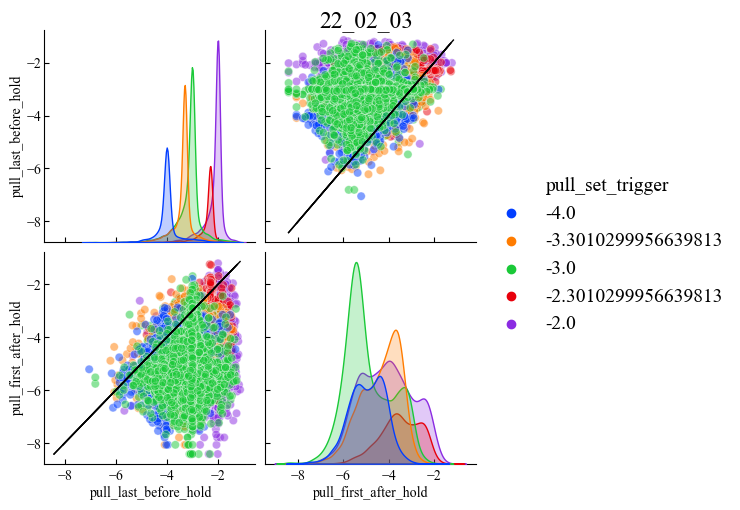

In [120]:
g = sns.pairplot(data=hold_df_pull_log, vars=['pull_last_before_hold', 'pull_first_after_hold'], # [hold_df_pull_log.index.isin(iv_good_pull)]
                 hue='pull_set_trigger', kind='scatter', plot_kws={'alpha': 0.5}, palette='bright')
g.fig.suptitle(f'{date}', y=1.01)
g.map_offdiag(plot_unity)

4


Text(0, 0.5, 'Counts [a.u.]')

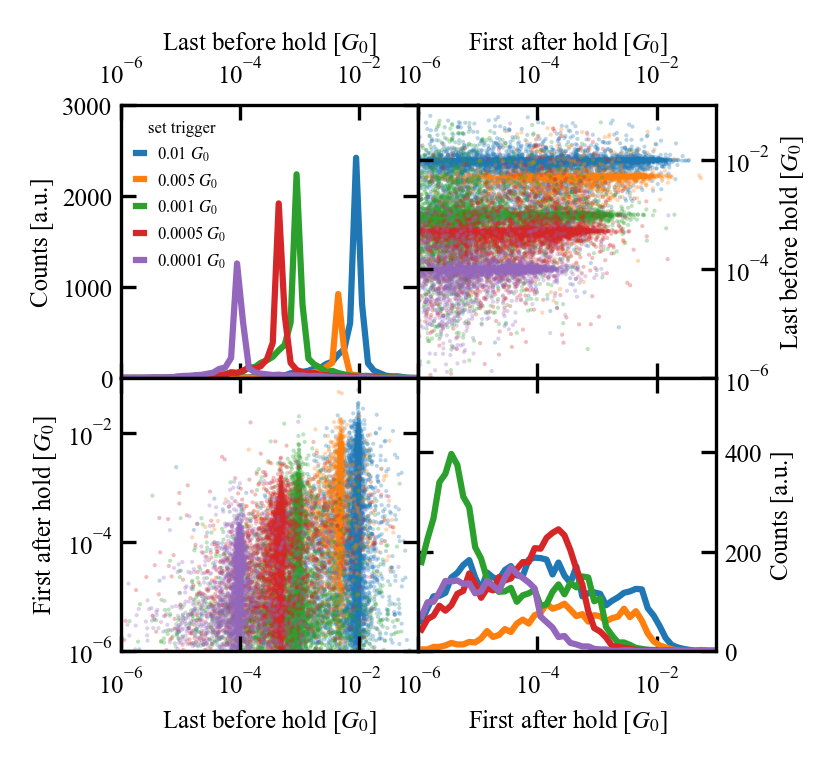

In [214]:
figsize = utils.cm2inch((6, 6))
dpi = 300

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(2, 2, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]

print(len(ax))

ax[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=True, labelbottom=False)
ax[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=True, labelbottom=False)
ax[2].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
ax[3].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=False, labelbottom=True)

ax[0].xaxis.set_label_position('top')
ax[1].xaxis.set_label_position('top')
ax[1].yaxis.set_label_position('right')
ax[3].yaxis.set_label_position('right')

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[3].set_xscale('log')

ax[0].set_xlim(1e-6, 1e-1)
ax[0].set_ylim(0, 3000)
ax[1].set_xlim(1e-6, 1e-1)
ax[1].set_ylim(1e-6, 1e-1)
ax[2].set_xlim(1e-6, 1e-1)
ax[2].set_ylim(1e-6, 1e-1)
ax[3].set_xlim(1e-6, 1e-1)
ax[3].set_ylim(0, 550)

for i, trig in enumerate(hold_df_pull['pull_set_trigger'].unique()):
    
    bins_1, hist_1d_1 = utils.calc_hist_1d_single(data=hold_df_pull[hold_df_pull['pull_set_trigger'] == trig]['pull_last_before_hold'], xrange=(1e-6, 1e-1),
                                                  xbins_num=10, log_scale=True, bin_mode='decade')

    bins_2, hist_1d_2 = utils.calc_hist_1d_single(data=hold_df_pull[hold_df_pull['pull_set_trigger'] == trig]['pull_first_after_hold'], xrange=(1e-6, 1e-1),
                                                  xbins_num=10, log_scale=True, bin_mode='decade')

    ax[0].plot(bins_1, hist_1d_1, label=str(trig) + r' $G_{0}$')
    ax[3].plot(bins_2, hist_1d_2, label=str(trig) + r' $G_{0}$')
    ax[1].scatter(hold_df_pull[hold_df_pull['pull_set_trigger'] == trig]['pull_first_after_hold'], hold_df_pull[hold_df_pull['pull_set_trigger'] == trig]['pull_last_before_hold'],
                  s=1, alpha=0.3, edgecolor='None', label=trig)
    ax[2].scatter(hold_df_pull[hold_df_pull['pull_set_trigger'] == trig]['pull_last_before_hold'], hold_df_pull[hold_df_pull['pull_set_trigger'] == trig]['pull_first_after_hold'],
                  s=1, alpha=0.3, edgecolor='None', label=trig)

ax[0].set_xlabel(r'Last before hold [$G_{0}$]')
ax[0].set_ylabel('Counts [a.u.]')

ax[1].set_ylabel(r'Last before hold [$G_{0}$]')
ax[1].set_xlabel(r'First after hold [$G_{0}$]')
ax[2].set_ylabel(r'First after hold [$G_{0}$]')
ax[2].set_xlabel(r'Last before hold [$G_{0}$]')

ax[0].legend(fontsize=4, handlelength=0.5, frameon=False, title='set trigger', title_fontproperties={'size': 4})

ax[3].set_xlabel(r'First after hold [$G_{0}$]')
ax[3].set_ylabel('Counts [a.u.]')

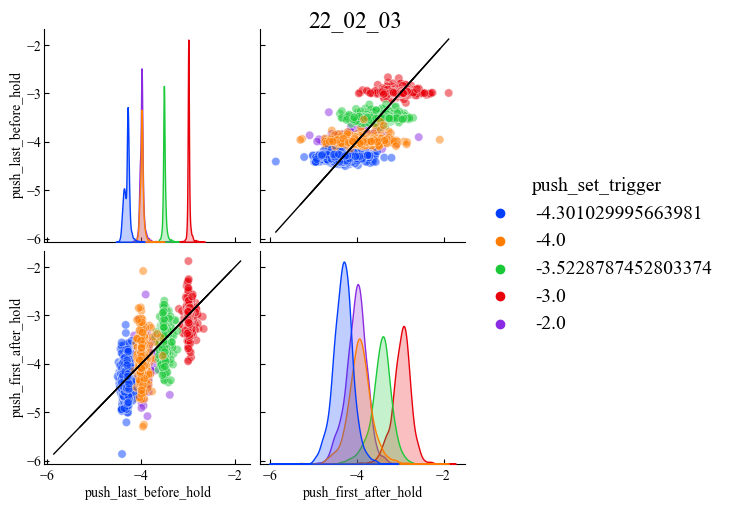

In [119]:
g = sns.pairplot(data=hold_df_push_log[hold_df_push_log.index.isin(iv_good_push)], vars=['push_last_before_hold', 'push_first_after_hold'],
                 hue='push_set_trigger', kind='scatter', plot_kws={'alpha': 0.5}, palette='bright')
g.fig.suptitle(f'{date}', y=1.01)
g.map_offdiag(plot_unity)

4


Text(0, 0.5, 'Counts [a.u.]')

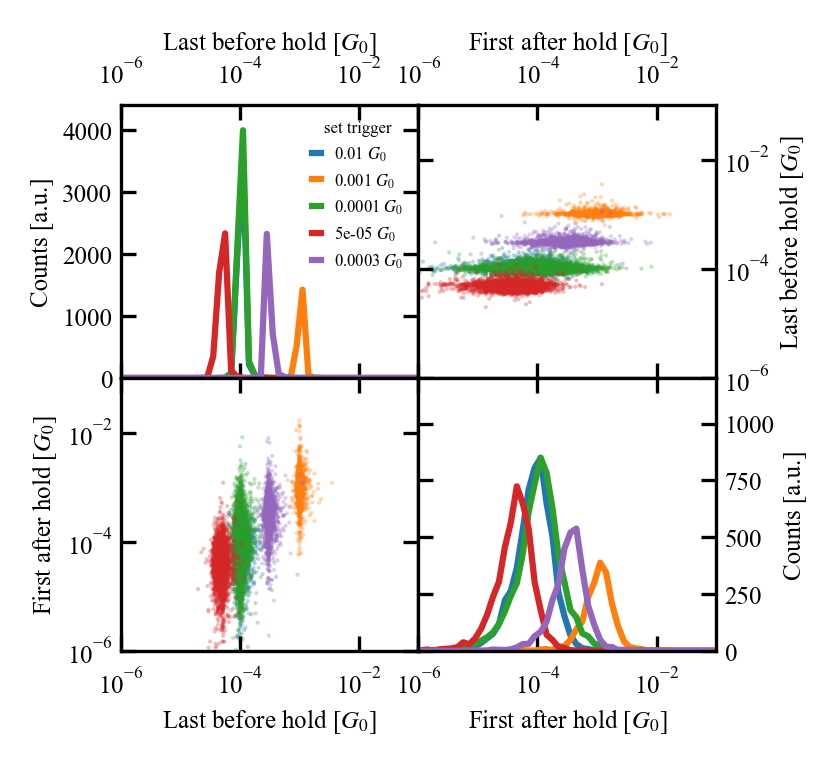

In [212]:
figsize = utils.cm2inch((6, 6))
dpi = 300

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(2, 2, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]

print(len(ax))

ax[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=True, labelbottom=False)
ax[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=True, labelbottom=False)
ax[2].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
ax[3].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=False, labelbottom=True)

ax[0].xaxis.set_label_position('top')
ax[1].xaxis.set_label_position('top')
ax[1].yaxis.set_label_position('right')
ax[3].yaxis.set_label_position('right')

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[3].set_xscale('log')

ax[0].set_xlim(1e-6, 1e-1)
ax[0].set_ylim(0, 4400)
ax[1].set_xlim(1e-6, 1e-1)
ax[1].set_ylim(1e-6, 1e-1)
ax[2].set_xlim(1e-6, 1e-1)
ax[2].set_ylim(1e-6, 1e-1)
ax[3].set_xlim(1e-6, 1e-1)
ax[3].set_ylim(0, 1200)

for i, trig in enumerate(hold_df_push['push_set_trigger'].unique()):
    
    bins_1, hist_1d_1 = utils.calc_hist_1d_single(data=hold_df_push[hold_df_push['push_set_trigger'] == trig]['push_last_before_hold'], xrange=(1e-6, 1e-1),
                                                  xbins_num=10, log_scale=True, bin_mode='decade')

    bins_2, hist_1d_2 = utils.calc_hist_1d_single(data=hold_df_push[hold_df_push['push_set_trigger'] == trig]['push_first_after_hold'], xrange=(1e-6, 1e-1),
                                                  xbins_num=10, log_scale=True, bin_mode='decade')

    ax[0].plot(bins_1, hist_1d_1, label=str(trig) + r' $G_{0}$')
    ax[3].plot(bins_2, hist_1d_2, label=str(trig) + r' $G_{0}$')
    ax[1].scatter(hold_df_push[hold_df_push['push_set_trigger'] == trig]['push_first_after_hold'], hold_df_push[hold_df_push['push_set_trigger'] == trig]['push_last_before_hold'],
                  s=1, alpha=0.3, edgecolor='None', label=trig)
    ax[2].scatter(hold_df_push[hold_df_push['push_set_trigger'] == trig]['push_last_before_hold'], hold_df_push[hold_df_push['push_set_trigger'] == trig]['push_first_after_hold'],
                  s=1, alpha=0.3, edgecolor='None', label=trig)

ax[0].set_xlabel(r'Last before hold [$G_{0}$]')
ax[0].set_ylabel('Counts [a.u.]')

ax[1].set_ylabel(r'Last before hold [$G_{0}$]')
ax[1].set_xlabel(r'First after hold [$G_{0}$]')
ax[2].set_ylabel(r'First after hold [$G_{0}$]')
ax[2].set_xlabel(r'Last before hold [$G_{0}$]')

ax[0].legend(fontsize=4, handlelength=0.5, frameon=False, title='set trigger', title_fontproperties={'size': 4})

ax[3].set_xlabel(r'First after hold [$G_{0}$]')
ax[3].set_ylabel('Counts [a.u.]')

In [30]:
my_cmap = ListedColormap(np.vstack((np.array([1., 1., 1., 0.]).reshape(1, -1), colormaps['viridis'](np.linspace(0.0, 1.0, 31)))))


my_cmap_blues = ListedColormap(np.vstack((np.array([1., 1., 1., 0.]).reshape(1, -1),
                                          colormaps['viridis'](np.linspace(0.0, 1.0, 31)))))
my_cmap_reds = ListedColormap(np.vstack((np.array([1., 1., 1., 0.]).reshape(1, -1),
                                         colormaps['plasma'](np.linspace(0.0, 1.0, 31)))))

In [135]:
sim_data_pull = pd.read_excel(io=home_folder.joinpath('results/IVs/selected/Tunnel_22_02_03_pull_fits_all.xlsx'))
sim_data_push = pd.read_excel(io=home_folder.joinpath('results/IVs/selected/Tunnel_22_02_03_push_fits_all.xlsx'))

In [136]:
sim_data_pull['Part'] = sim_data_pull['Fit Trace'].map(lambda x: int(re.search(r'(\d)\_IV\w*', x).group(1)))
sim_data_push['Part'] = sim_data_push['Fit Trace'].map(lambda x: int(re.search(r'(\d)\_IV\w*', x).group(1)))

In [137]:
sim_data_pull['G [G0]'] = sim_data_pull['R [Ohm]'].map(utils.convert_ohm_to_g0)
sim_data_push['G [G0]'] = sim_data_push['R [Ohm]'].map(utils.convert_ohm_to_g0)

In [138]:
sim_data_pull

,Trace,Fit Trace,R [Ohm],z -Gap [nm],Phi - Barrier [eV],dR/dz,dR/dPhi,G_meas1 [G0],dG/G_meas1,G_meas2 [G0],dG/G_meas2,Part,G [G0]
0,19522,'1_IV_trace_19522_pull_pl',13069957.0,0.32,0.77,1.563003e+17,1.099730e+26,0.002974,0.085796,0.001155,0.143681,1,0.000987
1,19811,'1_IV_trace_19811_pull_pl',3730296.1,0.21,0.92,5.156197e+16,1.692375e+25,0.005064,0.107289,0.002731,0.043851,1,0.003458
2,19877,'1_IV_trace_19877_pull_pl',2902911.0,0.18,1.20,4.417911e+16,1.010583e+25,0.006574,0.035293,0.004031,0.025566,1,0.004444
3,19905,'1_IV_trace_19905_pull_pl',1973310.2,0.18,0.59,2.518796e+16,1.007219e+25,0.011038,0.055643,0.007856,0.023391,1,0.006537
4,19998,'1_IV_trace_19998_pull_pl',4073626.3,0.20,1.26,6.184412e+16,1.569335e+25,0.005919,0.052609,0.002665,0.054060,1,0.003167
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10051,48577,'4_IV_trace_48577_pull_pl',18136585.0,0.26,2.06,3.121969e+17,7.843354e+25,0.000793,0.053881,0.000575,0.033965,4,0.000711
10052,48668,'4_IV_trace_48668_pull_pl',474985760.0,0.58,1.08,5.660299e+18,6.717272e+27,0.000072,0.168055,0.000056,0.071779,4,0.000027
10053,48837,'4_IV_trace_48837_pull_pl',13864712.0,0.24,2.18,2.457291e+17,5.370811e+25,0.002246,0.073720,0.001449,0.050695,4,0.000930
10054,48909,'4_IV_trace_48909_pull_pl',63364976.0,0.34,1.96,1.033247e+18,3.765722e+26,0.000408,0.037719,0.000161,0.050349,4,0.000204


In [141]:
noise_push = pd.read_csv(home_folder.joinpath('results/IVs/selected/noise_data_push.csv'))

In [142]:
noise_push

,trace_index,avg_cond_1,noise_power_1,conductance_noise_1,current_noise_1,avg_cond_2,noise_power_2,conductance_noise_2,current_noise_2
0,19515,0.000104,1.034398e-10,0.098067,0.098146,0.000115,2.828721e-11,0.046079,0.046120
1,19529,0.000081,3.261848e-11,0.070921,0.070965,0.000086,5.902757e-11,0.089175,0.089235
2,19535,0.000098,3.471378e-11,0.060375,0.060420,0.000077,1.038626e-10,0.131780,0.131859
3,19536,0.000123,1.708534e-10,0.105979,0.106080,0.000136,4.617942e-11,0.049800,0.049852
4,19568,0.000111,5.898702e-11,0.069067,0.069126,0.000122,9.207404e-11,0.078762,0.078836
...,...,...,...,...,...,...,...,...,...
6214,49057,0.000080,5.098413e-10,0.283386,0.283561,0.000102,2.012042e-10,0.138958,0.139068
6215,49067,0.000160,9.173187e-11,0.059936,0.060010,0.000397,3.471137e-10,0.046973,0.047117
6216,49072,0.000086,8.167860e-11,0.104733,0.104803,0.000123,8.194543e-11,0.073369,0.073439
6217,49083,0.000113,9.997313e-11,0.088571,0.088648,0.000294,2.459767e-09,0.168821,0.169205


In [145]:
noise_push['avg_cond_1'].to_numpy()

array([1.03710338e-04, 8.05298520e-05, 9.75877961e-05, ...,
       8.62921299e-05, 1.12889001e-04, 6.65253881e-05])

In [147]:
np.vstack((noise_push['avg_cond_1'],
           noise_push['avg_cond_1'], 
           noise_push['avg_cond_1'], 
           noise_push['avg_cond_1'])).T.flatten()

array([1.03710338e-04, 1.03710338e-04, 1.03710338e-04, ...,
       6.65253881e-05, 6.65253881e-05, 6.65253881e-05])

In [148]:
sim_data_push = sim_data_push.sort_values(by=['Trace', 'Part'])

In [152]:
sim_data_push['G_meas1 [G0]'] = np.vstack((noise_push['avg_cond_1'],
                                           noise_push['avg_cond_1'], 
                                           noise_push['avg_cond_1'], 
                                           noise_push['avg_cond_1'])).T.flatten()

sim_data_push['G_meas2 [G0]'] = np.vstack((noise_push['avg_cond_2'],
                                           noise_push['avg_cond_2'], 
                                           noise_push['avg_cond_2'], 
                                           noise_push['avg_cond_2'])).T.flatten()

sim_data_push['dG/G_meas1'] = np.vstack((noise_push['conductance_noise_1'],
                                         noise_push['conductance_noise_1'], 
                                         noise_push['conductance_noise_1'], 
                                         noise_push['conductance_noise_1'])).T.flatten()

sim_data_push['dG/G_meas2'] = np.vstack((noise_push['conductance_noise_2'],
                                         noise_push['conductance_noise_2'], 
                                         noise_push['conductance_noise_2'], 
                                         noise_push['conductance_noise_2'])).T.flatten()

In [153]:
sim_data_push

,Trace,Fit Trace,R [Ohm],z -Gap [nm],Phi - Barrier [eV],dR/dz,dR/dPhi,G_meas1 [G0],dG/G_meas1,G_meas2 [G0],dG/G_meas2,Part,G [G0]
0,19515,'1_IV_trace_19515_push_pl',123337740.0,0.43,1.38,1.690506e+18,1.103075e+27,0.000104,0.098067,0.000115,0.046079,1,0.000105
4413,19515,'2_IV_trace_19515_push_pl',115852820.0,0.41,1.54,1.670889e+18,9.379184e+26,0.000104,0.098067,0.000115,0.046079,2,0.000111
8826,19515,'3_IV_trace_19515_push_pl',118121180.0,0.43,1.35,1.605310e+18,1.066052e+27,0.000104,0.098067,0.000115,0.046079,3,0.000109
13239,19515,'4_IV_trace_19515_push_pl',115108080.0,0.48,0.96,1.354317e+18,1.531600e+27,0.000104,0.098067,0.000115,0.046079,4,0.000112
1,19529,'1_IV_trace_19529_push_pl',172076560.0,0.53,0.88,1.912228e+18,2.374670e+27,0.000081,0.070921,0.000086,0.089175,1,0.000075
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24874,49083,'4_IV_trace_49083_push_pl',93806128.0,0.35,2.20,1.595239e+18,5.499750e+26,0.000113,0.088571,0.000294,0.168821,4,0.000138
19457,49088,'1_IV_trace_49088_push_pl',195853160.0,0.47,1.33,2.604451e+18,1.969822e+27,0.000067,0.066466,0.000087,0.032976,1,0.000066
21263,49088,'2_IV_trace_49088_push_pl',201705620.0,0.50,1.13,2.508884e+18,2.352905e+27,0.000067,0.066466,0.000087,0.032976,2,0.000064
23069,49088,'3_IV_trace_49088_push_pl',224151430.0,0.52,1.06,2.703747e+18,2.815920e+27,0.000067,0.066466,0.000087,0.032976,3,0.000058


In [154]:
# REORDER COLUMNS
sim_data_pull = sim_data_pull[['Trace', 'Part', 'G [G0]', 'R [Ohm]', 'z -Gap [nm]', 'Phi - Barrier [eV]', 'dR/dz', 'dR/dPhi', 'G_meas1 [G0]', 'dG/G_meas1', 'G_meas2 [G0]', 'dG/G_meas2', 'Fit Trace']]
sim_data_push = sim_data_push[['Trace', 'Part', 'G [G0]', 'R [Ohm]', 'z -Gap [nm]', 'Phi - Barrier [eV]', 'dR/dz', 'dR/dPhi', 'G_meas1 [G0]', 'dG/G_meas1', 'G_meas2 [G0]', 'dG/G_meas2', 'Fit Trace']]

In [155]:
warnings.filterwarnings("default")

In [156]:
sim_data_pull['dG/G_sim_gap'] = calc_noise_sim(sim_data_pull, dgap=3e-3, dphi=0)
sim_data_pull['dG/G_sim_phi'] = calc_noise_sim(sim_data_pull, dgap=0, dphi=33e-3)
sim_data_pull['dG/G_sim_gap_phi'] = calc_noise_sim(sim_data_pull, dgap=1.5e-3, dphi=33e-3)

Calculating relative noise when the barrier fluctuation is dphi=0 eV and the gap fluctuation is dgap=0.003 nm.
Calculating relative noise when the barrier fluctuation is dphi=0.033 eV and the gap fluctuation is dgap=0 nm.
Calculating relative noise when the barrier fluctuation is dphi=0.033 eV and the gap fluctuation is dgap=0.0015 nm.


C:\Users\Admin\AppData\Local\Temp\ipykernel_11680\3624936959.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim_data_pull['dG/G_sim_gap'] = calc_noise_sim(sim_data_pull, dgap=3e-3, dphi=0)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11680\3624936959.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim_data_pull['dG/G_sim_phi'] = calc_noise_sim(sim_data_pull, dgap=0, dphi=33e-3)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11680\3624936959.py:3: SettingWithCopyWarning: 
A value is trying to be set on 

In [157]:
sim_data_push['dG/G_sim_gap'] = calc_noise_sim(sim_data_push, dgap=3e-3, dphi=0)
sim_data_push['dG/G_sim_phi'] = calc_noise_sim(sim_data_push, dgap=0, dphi=33e-3)
sim_data_push['dG/G_sim_gap_phi'] = calc_noise_sim(sim_data_push, dgap=1.5e-3, dphi=33e-3)

Calculating relative noise when the barrier fluctuation is dphi=0 eV and the gap fluctuation is dgap=0.003 nm.
Calculating relative noise when the barrier fluctuation is dphi=0.033 eV and the gap fluctuation is dgap=0 nm.
Calculating relative noise when the barrier fluctuation is dphi=0.033 eV and the gap fluctuation is dgap=0.0015 nm.


C:\Users\Admin\AppData\Local\Temp\ipykernel_11680\3816215006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim_data_push['dG/G_sim_gap'] = calc_noise_sim(sim_data_push, dgap=3e-3, dphi=0)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11680\3816215006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim_data_push['dG/G_sim_phi'] = calc_noise_sim(sim_data_push, dgap=0, dphi=33e-3)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11680\3816215006.py:3: SettingWithCopyWarning: 
A value is trying to be set on 

In [158]:
sim_data_pull.sort_values(by=['Trace', 'Part'])

,Trace,Part,G [G0],R [Ohm],z -Gap [nm],Phi - Barrier [eV],dR/dz,dR/dPhi,G_meas1 [G0],dG/G_meas1,G_meas2 [G0],dG/G_meas2,Fit Trace,dG/G_sim_gap,dG/G_sim_phi,dG/G_sim_gap_phi
0,19522,1,0.000987,13069957.0,0.32,0.77,1.563003e+17,1.099730e+26,0.002974,0.085796,0.001155,0.143681,'1_IV_trace_19522_pull_pl',0.035876,0.044427,0.047912
639,19522,2,0.000994,12976073.0,0.33,0.68,1.483611e+17,1.122828e+26,0.002974,0.085796,0.001155,0.143681,'2_IV_trace_19522_pull_pl',0.034300,0.045688,0.048801
1278,19522,3,0.000749,17213803.0,0.27,1.76,2.784074e+17,8.233249e+25,0.002974,0.085796,0.001155,0.143681,'3_IV_trace_19522_pull_pl',0.048521,0.025254,0.035019
1917,19522,4,0.000629,20498335.0,0.36,0.76,2.371568e+17,1.994190e+26,0.002974,0.085796,0.001155,0.143681,'4_IV_trace_19522_pull_pl',0.034709,0.051367,0.054219
1,19811,1,0.003458,3730296.1,0.21,0.92,5.156197e+16,1.692375e+25,0.005064,0.107289,0.002731,0.043851,'1_IV_trace_19811_pull_pl',0.041467,0.023955,0.031681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10054,48909,4,0.000204,63364976.0,0.34,1.96,1.033247e+18,3.765722e+26,0.000408,0.037719,0.000161,0.050349,'4_IV_trace_48909_pull_pl',0.048919,0.031379,0.039785
4430,49042,1,0.000769,16774953.0,0.33,0.87,2.068231e+17,1.323794e+26,0.001002,0.032493,0.000760,0.021734,'1_IV_trace_49042_pull_pl',0.036988,0.041667,0.045587
6305,49042,2,0.000809,15951589.0,0.32,0.93,2.029315e+17,1.186968e+26,0.001002,0.032493,0.000760,0.021734,'2_IV_trace_49042_pull_pl',0.038165,0.039289,0.043678
8180,49042,3,0.000687,18777990.0,0.32,1.07,2.507298e+17,1.328797e+26,0.001002,0.032493,0.000760,0.021734,'3_IV_trace_49042_pull_pl',0.040057,0.037363,0.042393


In [159]:
sim_data_push.sort_values(by=['Trace', 'Part'])

,Trace,Part,G [G0],R [Ohm],z -Gap [nm],Phi - Barrier [eV],dR/dz,dR/dPhi,G_meas1 [G0],dG/G_meas1,G_meas2 [G0],dG/G_meas2,Fit Trace,dG/G_sim_gap,dG/G_sim_phi,dG/G_sim_gap_phi
0,19515,1,0.000105,123337740.0,0.43,1.38,1.690506e+18,1.103075e+27,0.000104,0.098067,0.000115,0.046079,'1_IV_trace_19515_push_pl',0.041119,0.047222,0.051503
4413,19515,2,0.000111,115852820.0,0.41,1.54,1.670889e+18,9.379184e+26,0.000104,0.098067,0.000115,0.046079,'2_IV_trace_19515_push_pl',0.043268,0.042746,0.047908
8826,19515,3,0.000109,118121180.0,0.43,1.35,1.605310e+18,1.066052e+27,0.000104,0.098067,0.000115,0.046079,'3_IV_trace_19515_push_pl',0.040771,0.047652,0.051830
13239,19515,4,0.000112,115108080.0,0.48,0.96,1.354317e+18,1.531600e+27,0.000104,0.098067,0.000115,0.046079,'4_IV_trace_19515_push_pl',0.035297,0.070254,0.072437
1,19529,1,0.000075,172076560.0,0.53,0.88,1.912228e+18,2.374670e+27,0.000081,0.070921,0.000086,0.089175,'1_IV_trace_19529_push_pl',0.033338,0.072864,0.074747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24874,49083,4,0.000138,93806128.0,0.35,2.20,1.595239e+18,5.499750e+26,0.000113,0.088571,0.000294,0.168821,'4_IV_trace_49083_push_pl',0.051017,0.030956,0.040112
19457,49088,1,0.000066,195853160.0,0.47,1.33,2.604451e+18,1.969822e+27,0.000067,0.066466,0.000087,0.032976,'1_IV_trace_49088_push_pl',0.039894,0.053104,0.056727
21263,49088,2,0.000064,201705620.0,0.50,1.13,2.508884e+18,2.352905e+27,0.000067,0.066466,0.000087,0.032976,'2_IV_trace_49088_push_pl',0.037315,0.061591,0.064355
23069,49088,3,0.000058,224151430.0,0.52,1.06,2.703747e+18,2.815920e+27,0.000067,0.066466,0.000087,0.032976,'3_IV_trace_49088_push_pl',0.036186,0.066330,0.068754


In [160]:
# x_bins, x_hist1d = utils.calc_hist_1d_single(data=sim_data_pull['G_meas2 [G0]'], xrange=(1e-5, 1e-1),
#                                              xbins_num=100, log_scale=True, bin_mode='total')
# y_bins, y_hist1d = utils.calc_hist_1d_single(data=sim_data_pull['dG/G_meas2'], xrange=(1e-2, 1),
#                                              xbins_num=100, log_scale=True, bin_mode='total')

# h, xedges, yedges = np.histogram2d(sim_data_pull['G_meas2 [G0]'], sim_data_pull['dG/G_meas2'],
#                                    bins=[x_bins, y_bins])
# x_mesh, y_mesh = np.meshgrid(xedges, yedges)

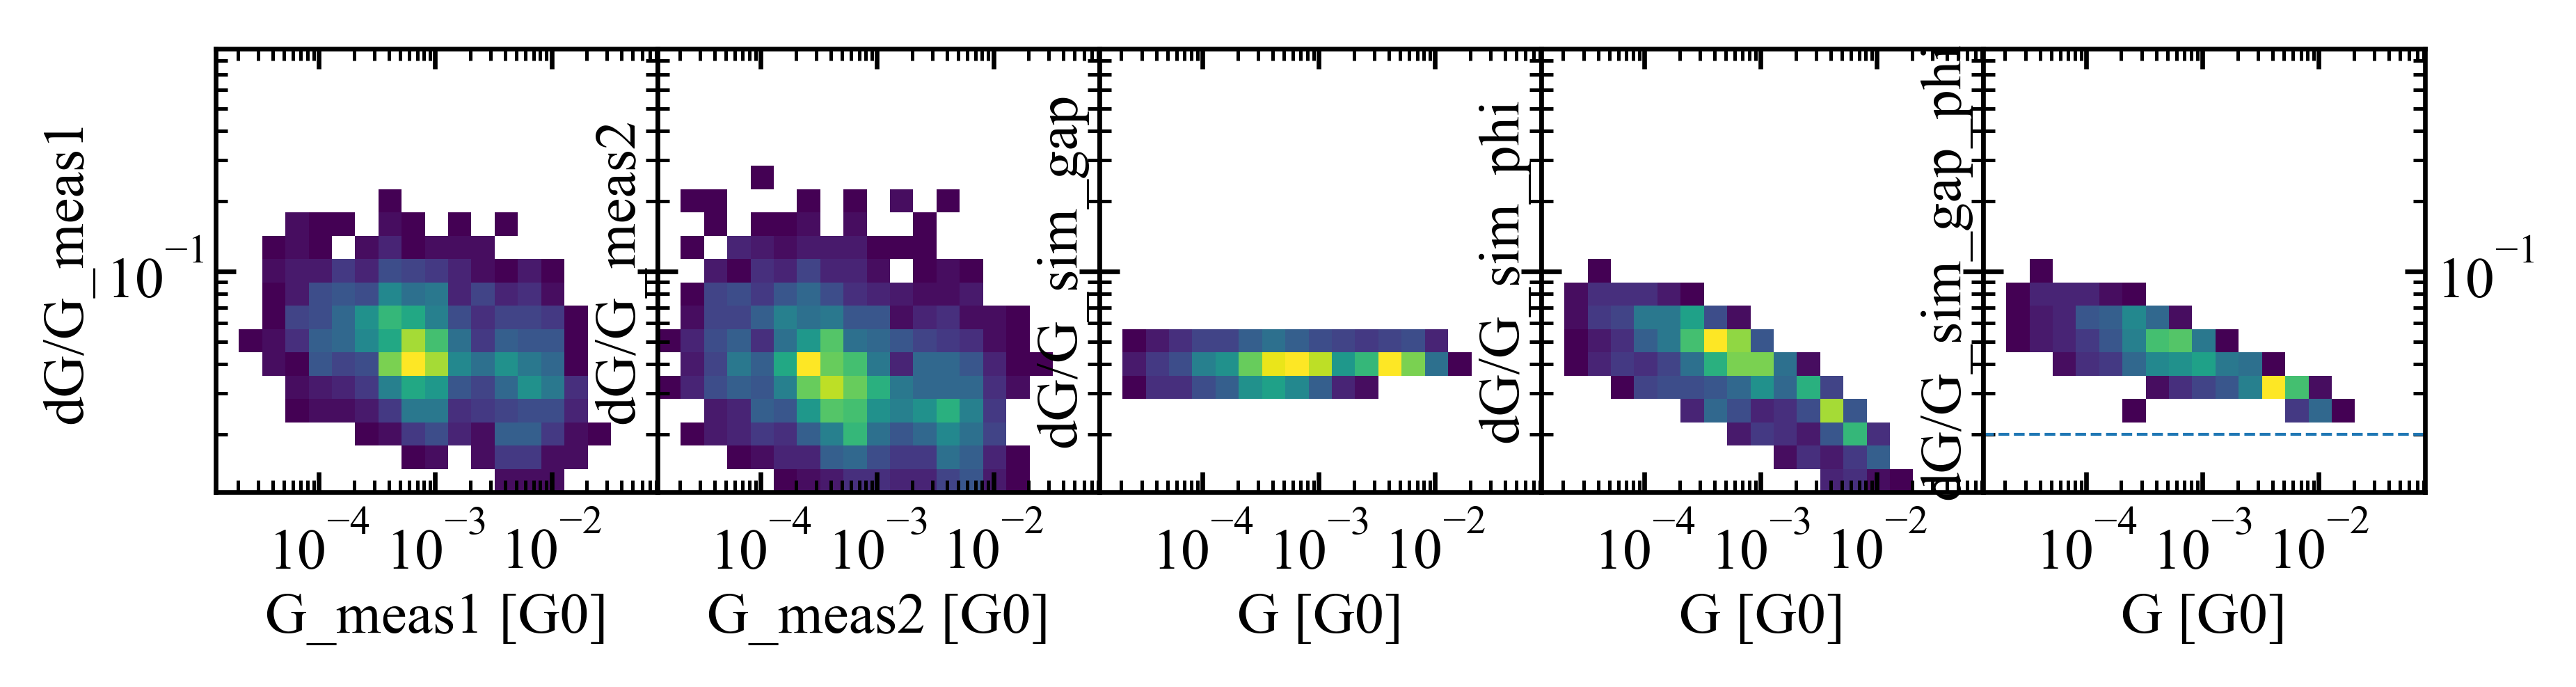

In [161]:
fig, ax = plot_2D_rel_noise_hists(sim_data_pull,
                                  x_vars=('G_meas1 [G0]', 'G_meas2 [G0]', 'G [G0]', 'G [G0]', 'G [G0]'),
                                  y_vars=('dG/G_meas1', 'dG/G_meas2', 'dG/G_sim_gap', 'dG/G_sim_phi', 'dG/G_sim_gap_phi'),
                                  xrange=(1e-5, 1e-1), yrange=(1e-2, 1), xbins_num=20, ybins_num=20, cmap=my_cmap_blues, figsize=utils.cm2inch(16, 3.5))

ax[-1].axhline(2e-2, ls='--', lw=0.5)

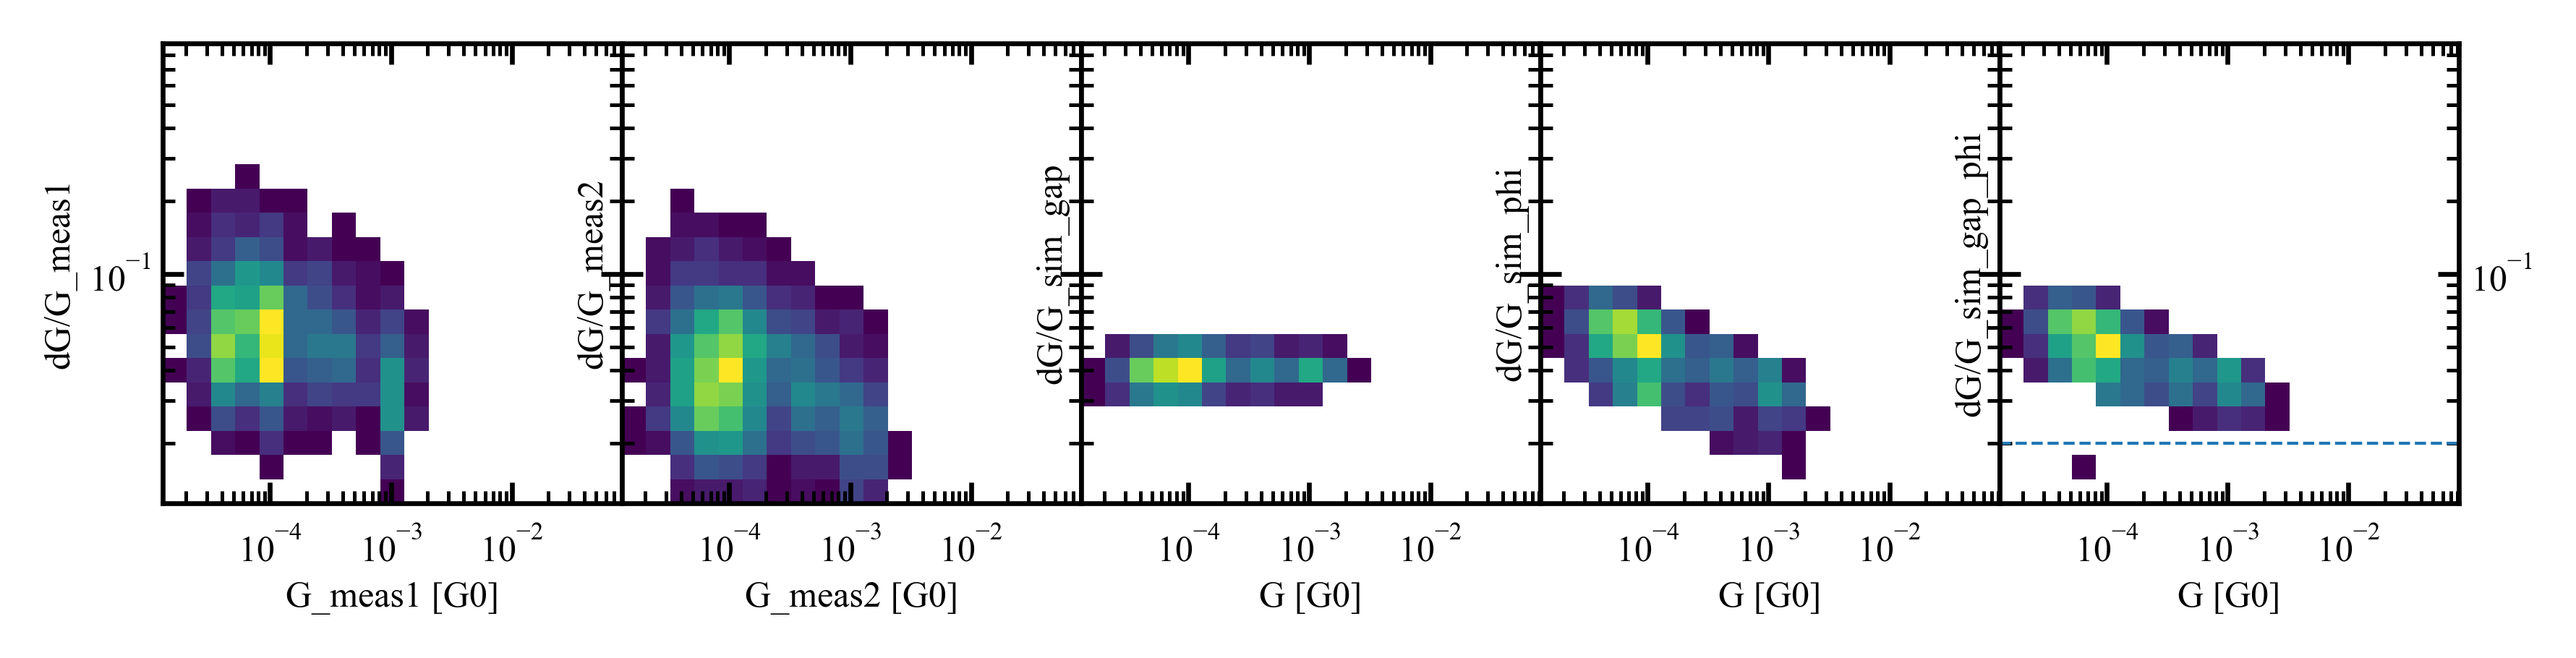

In [222]:
fig, ax = plot_2D_rel_noise_hists(sim_data_push,
                                  x_vars=('G_meas1 [G0]', 'G_meas2 [G0]', 'G [G0]', 'G [G0]', 'G [G0]'),
                                  y_vars=('dG/G_meas1', 'dG/G_meas2', 'dG/G_sim_gap', 'dG/G_sim_phi', 'dG/G_sim_gap_phi'),
                                  xrange=(1e-5, 1e-1), yrange=(1e-2, 1), xbins_num=20, ybins_num=20, cmap=my_cmap_blues, figsize=utils.cm2inch(16, 3.5))

ax[-1].axhline(2e-2, ls='--', lw=0.5)

In [163]:
sim_data_push

,Trace,Part,G [G0],R [Ohm],z -Gap [nm],Phi - Barrier [eV],dR/dz,dR/dPhi,G_meas1 [G0],dG/G_meas1,G_meas2 [G0],dG/G_meas2,Fit Trace,dG/G_sim_gap,dG/G_sim_phi,dG/G_sim_gap_phi
0,19515,1,0.000105,123337740.0,0.43,1.38,1.690506e+18,1.103075e+27,0.000104,0.098067,0.000115,0.046079,'1_IV_trace_19515_push_pl',0.041119,0.047222,0.051503
4413,19515,2,0.000111,115852820.0,0.41,1.54,1.670889e+18,9.379184e+26,0.000104,0.098067,0.000115,0.046079,'2_IV_trace_19515_push_pl',0.043268,0.042746,0.047908
8826,19515,3,0.000109,118121180.0,0.43,1.35,1.605310e+18,1.066052e+27,0.000104,0.098067,0.000115,0.046079,'3_IV_trace_19515_push_pl',0.040771,0.047652,0.051830
13239,19515,4,0.000112,115108080.0,0.48,0.96,1.354317e+18,1.531600e+27,0.000104,0.098067,0.000115,0.046079,'4_IV_trace_19515_push_pl',0.035297,0.070254,0.072437
1,19529,1,0.000075,172076560.0,0.53,0.88,1.912228e+18,2.374670e+27,0.000081,0.070921,0.000086,0.089175,'1_IV_trace_19529_push_pl',0.033338,0.072864,0.074747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24874,49083,4,0.000138,93806128.0,0.35,2.20,1.595239e+18,5.499750e+26,0.000113,0.088571,0.000294,0.168821,'4_IV_trace_49083_push_pl',0.051017,0.030956,0.040112
19457,49088,1,0.000066,195853160.0,0.47,1.33,2.604451e+18,1.969822e+27,0.000067,0.066466,0.000087,0.032976,'1_IV_trace_49088_push_pl',0.039894,0.053104,0.056727
21263,49088,2,0.000064,201705620.0,0.50,1.13,2.508884e+18,2.352905e+27,0.000067,0.066466,0.000087,0.032976,'2_IV_trace_49088_push_pl',0.037315,0.061591,0.064355
23069,49088,3,0.000058,224151430.0,0.52,1.06,2.703747e+18,2.815920e+27,0.000067,0.066466,0.000087,0.032976,'3_IV_trace_49088_push_pl',0.036186,0.066330,0.068754


In [164]:
warnings.filterwarnings("default")

In [165]:
dz = 3e-3
dP = 30e-3
dzdP = (1e-3, 30e-3)

sim_data_pull['dG/G_sim_gap'] = calc_noise_sim(sim_data_pull, dgap=dz, dphi=0)
sim_data_pull['dG/G_sim_phi'] = calc_noise_sim(sim_data_pull, dgap=0, dphi=dP)
sim_data_pull['dG/G_sim_gap_phi'] = calc_noise_sim(sim_data_pull, dgap=dzdP[0], dphi=dzdP[1])

sim_data_push['dG/G_sim_gap'] = calc_noise_sim(sim_data_push, dgap=dz, dphi=0)
sim_data_push['dG/G_sim_phi'] = calc_noise_sim(sim_data_push, dgap=0, dphi=dP)
sim_data_push['dG/G_sim_gap_phi'] = calc_noise_sim(sim_data_push, dgap=dzdP[0], dphi=dzdP[1])

Calculating relative noise when the barrier fluctuation is dphi=0 eV and the gap fluctuation is dgap=0.003 nm.
Calculating relative noise when the barrier fluctuation is dphi=0.03 eV and the gap fluctuation is dgap=0 nm.
Calculating relative noise when the barrier fluctuation is dphi=0.03 eV and the gap fluctuation is dgap=0.001 nm.
Calculating relative noise when the barrier fluctuation is dphi=0 eV and the gap fluctuation is dgap=0.003 nm.
Calculating relative noise when the barrier fluctuation is dphi=0.03 eV and the gap fluctuation is dgap=0 nm.
Calculating relative noise when the barrier fluctuation is dphi=0.03 eV and the gap fluctuation is dgap=0.001 nm.


C:\Users\Admin\AppData\Local\Temp\ipykernel_11680\3819899633.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim_data_pull['dG/G_sim_gap'] = calc_noise_sim(sim_data_pull, dgap=dz, dphi=0)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11680\3819899633.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim_data_pull['dG/G_sim_phi'] = calc_noise_sim(sim_data_pull, dgap=0, dphi=dP)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11680\3819899633.py:7: SettingWithCopyWarning: 
A value is trying to be set on a cop

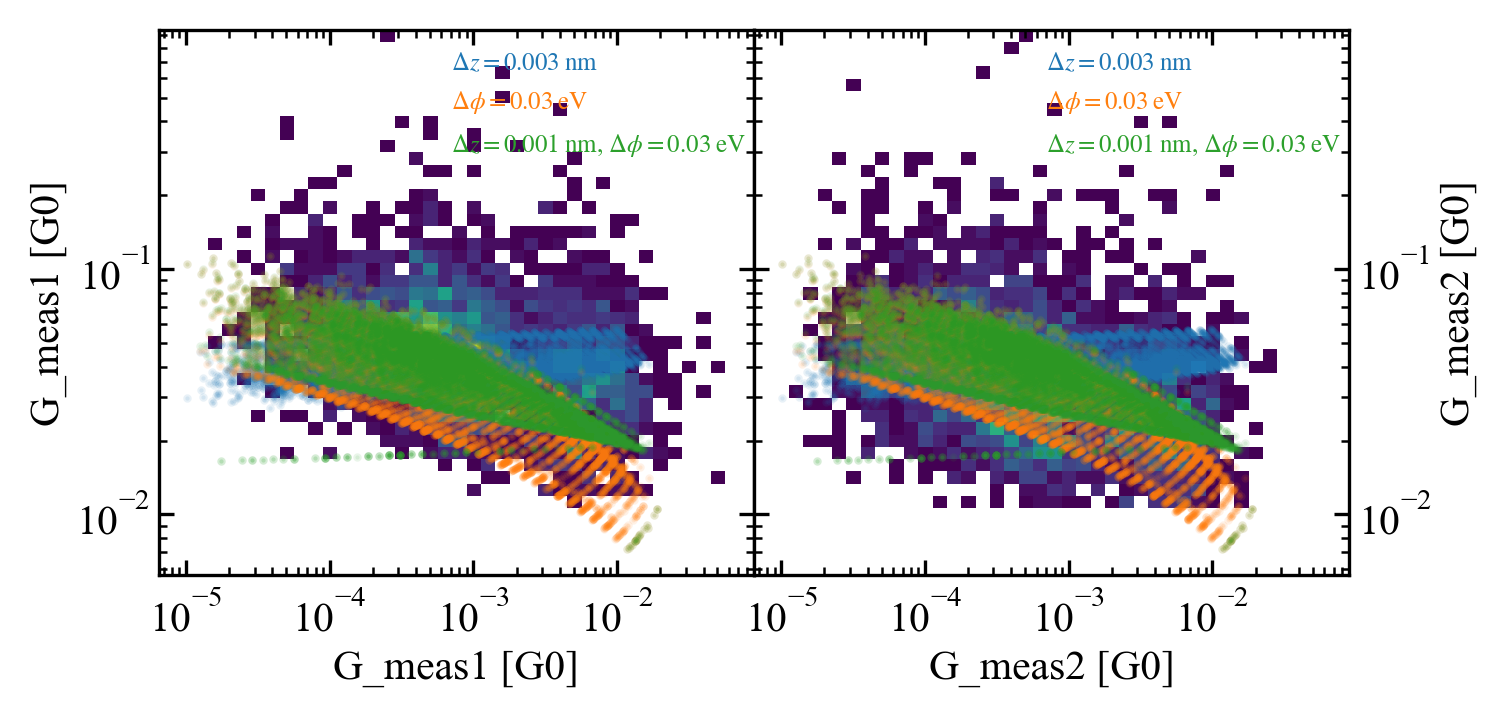

In [166]:
fig, ax = plot_2D_rel_noise_hist_and_scatter(df=sim_data_pull,
                                             x_2d_vars=('G_meas1 [G0]', 'G_meas2 [G0]'), y_2d_vars=('dG/G_meas1', 'dG/G_meas2'),
                                             x_scat_vars=('G [G0]', 'G [G0]', 'G [G0]'), y_scat_vars=('dG/G_sim_gap', 'dG/G_sim_phi', 'dG/G_sim_gap_phi'),
                                             xrange=(1e-5, 1e-1), yrange=(1e-2, 1), xbins_num=40, ybins_num=40,
                                             cmap=my_cmap_blues, figsize=utils.cm2inch(12, 6), dpi=300, s=1, alpha=0.1)

ax[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
ax[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=False, labelbottom=True)
ax[1].yaxis.set_label_position('right')

ax[0].text(x=7e-4, y=6.5e-1, s=r'$\Delta z = ' + f'{dz}' + r'\;\mathrm{nm}$', c='tab:blue', fontsize=6)
ax[0].text(x=7e-4, y=4.5e-1, s=r'$\Delta \phi = ' + f'{dP}' + r'\;\mathrm{eV}$', c='tab:orange', fontsize=6)
ax[0].text(x=7e-4, y=3.0e-1, s=r'$\Delta z = ' + f'{dzdP[0]}' +r'\;\mathrm{nm}$,' + r' $\Delta \phi = ' + f'{dzdP[1]}' +r'\;\mathrm{eV}$', c='tab:green', fontsize=6)

ax[1].text(x=7e-4, y=6.5e-1, s=r'$\Delta z = ' + f'{dz}' + r'\;\mathrm{nm}$', c='tab:blue', fontsize=6)
ax[1].text(x=7e-4, y=4.5e-1, s=r'$\Delta \phi = ' + f'{dP}' + r'\;\mathrm{eV}$', c='tab:orange', fontsize=6)
ax[1].text(x=7e-4, y=3.0e-1, s=r'$\Delta z = ' + f'{dzdP[0]}' +r'\;\mathrm{nm}$,' + r' $\Delta \phi = ' + f'{dzdP[1]}' +r'\;\mathrm{eV}$', c='tab:green', fontsize=6)

ax[0].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[0].xaxis.set_minor_formatter(ticker.NullFormatter())
ax[1].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[1].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[1].xaxis.set_minor_formatter(ticker.NullFormatter())

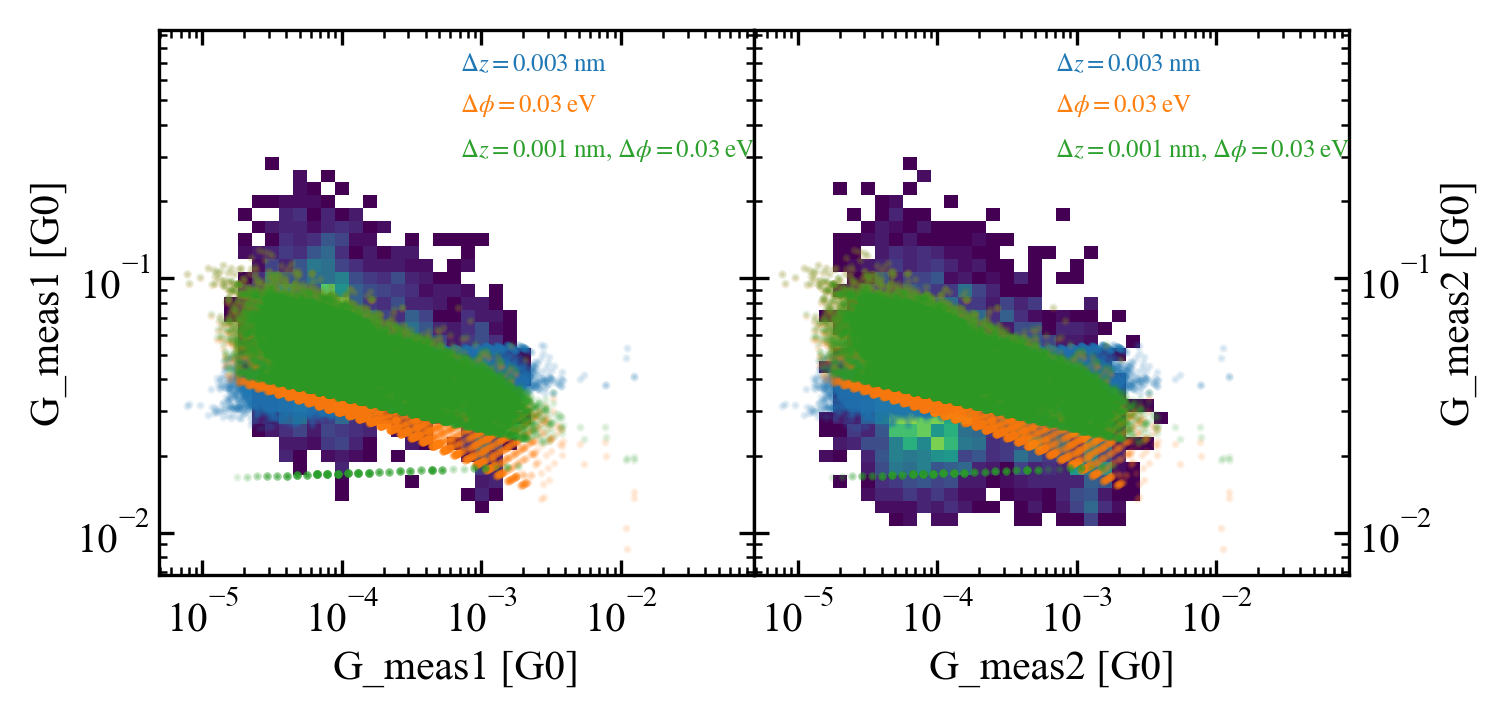

In [167]:
fig, ax = plot_2D_rel_noise_hist_and_scatter(df=sim_data_push,
                                             x_2d_vars=('G_meas1 [G0]', 'G_meas2 [G0]'), y_2d_vars=('dG/G_meas1', 'dG/G_meas2'),
                                             x_scat_vars=('G [G0]', 'G [G0]', 'G [G0]'), y_scat_vars=('dG/G_sim_gap', 'dG/G_sim_phi', 'dG/G_sim_gap_phi'),
                                             xrange=(1e-5, 1e-1), yrange=(1e-2, 1), xbins_num=40, ybins_num=40,
                                             cmap=my_cmap_blues, figsize=utils.cm2inch(12, 6), dpi=300, s=1, alpha=0.1)

ax[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
ax[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=False, labelbottom=True)
ax[1].yaxis.set_label_position('right')

ax[0].text(x=7e-4, y=6.5e-1, s=r'$\Delta z = ' + f'{dz}' + r'\;\mathrm{nm}$', c='tab:blue', fontsize=6)
ax[0].text(x=7e-4, y=4.5e-1, s=r'$\Delta \phi = ' + f'{dP}' + r'\;\mathrm{eV}$', c='tab:orange', fontsize=6)
ax[0].text(x=7e-4, y=3.0e-1, s=r'$\Delta z = ' + f'{dzdP[0]}' +r'\;\mathrm{nm}$,' + r' $\Delta \phi = ' + f'{dzdP[1]}' +r'\;\mathrm{eV}$', c='tab:green', fontsize=6)

ax[1].text(x=7e-4, y=6.5e-1, s=r'$\Delta z = ' + f'{dz}' + r'\;\mathrm{nm}$', c='tab:blue', fontsize=6)
ax[1].text(x=7e-4, y=4.5e-1, s=r'$\Delta \phi = ' + f'{dP}' + r'\;\mathrm{eV}$', c='tab:orange', fontsize=6)
ax[1].text(x=7e-4, y=3.0e-1, s=r'$\Delta z = ' + f'{dzdP[0]}' +r'\;\mathrm{nm}$,' + r' $\Delta \phi = ' + f'{dzdP[1]}' +r'\;\mathrm{eV}$', c='tab:green', fontsize=6)

ax[0].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[0].xaxis.set_minor_formatter(ticker.NullFormatter())
ax[1].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[1].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[1].xaxis.set_minor_formatter(ticker.NullFormatter())

In [172]:
sim_data_pull.columns

Index(['Trace', 'Part', 'G [G0]', 'R [Ohm]', 'z -Gap [nm]',
       'Phi - Barrier [eV]', 'dR/dz', 'dR/dPhi', 'G_meas1 [G0]', 'dG/G_meas1',
       'G_meas2 [G0]', 'dG/G_meas2', 'Fit Trace', 'dG/G_sim_gap',
       'dG/G_sim_phi', 'dG/G_sim_gap_phi'],
      dtype='object')

In [184]:
rcParams['font.size'] = 14
rcParams['ytick.labelsize'] = 6
rcParams['xtick.labelsize'] = 6
rcParams['axes.labelsize'] = 6

4


Text(0.5, 0, 'Phi - Barrier [eV]')

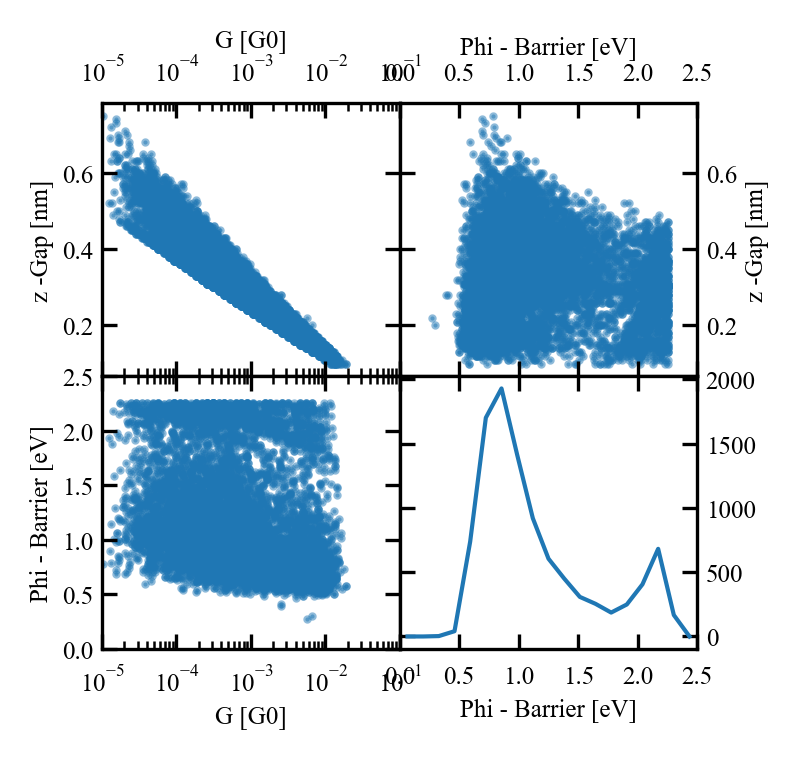

In [195]:
figsize = utils.cm2inch((6, 6))
dpi = 300

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(2, 2, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]

print(len(ax))

ax[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=True, labelbottom=False)
ax[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=True, labelbottom=False)
ax[2].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
ax[3].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=False, labelbottom=True)

ax[0].xaxis.set_label_position('top')
ax[1].xaxis.set_label_position('top')
ax[1].yaxis.set_label_position('right')
ax[3].yaxis.set_label_position('right')

ax[0].scatter(sim_data_pull['G [G0]'], sim_data_pull['z -Gap [nm]'], s=1, alpha=0.5)
ax[0].set_xlabel('G [G0]')
ax[0].set_xlim(1e-5, 1e-1)
ax[0].set_xscale('log')
ax[0].set_ylabel('z -Gap [nm]')

ax[0].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[0].xaxis.set_minor_formatter(ticker.NullFormatter())

ax[2].scatter(sim_data_pull['G [G0]'], sim_data_pull['Phi - Barrier [eV]'], s=1, alpha=0.5)
ax[2].set_xlabel('G [G0]')
ax[2].set_xlim(1e-5, 1e-1)
ax[2].set_xscale('log')
ax[2].set_ylabel('Phi - Barrier [eV]')
ax[2].set_ylim(0, 2.5)

ax[2].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[2].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[2].xaxis.set_minor_formatter(ticker.NullFormatter())

ax[1].scatter(sim_data_pull['Phi - Barrier [eV]'], sim_data_pull['z -Gap [nm]'], s=1, alpha=0.5)
ax[1].set_xlabel('Phi - Barrier [eV]')
ax[1].set_xlim(0, 2.5)
ax[1].set_xticks(np.arange(0, 2.51, 0.5))
ax[1].set_ylabel('z -Gap [nm]')
phi_bins, phi_hist1d = utils.calc_hist_1d_single(data=sim_data_pull['Phi - Barrier [eV]'], xrange=(0, 2.5),
                                                 xbins_num=20, log_scale=False, bin_mode='total')

ax[3].plot(phi_bins, phi_hist1d, lw=1)
ax[3].set_xlim(0, 2.5)
ax[3].set_xticks(np.arange(0, 2.51, 0.5))
ax[3].set_xlabel('Phi - Barrier [eV]')

4


Text(0.5, 0, 'Phi - Barrier [eV]')

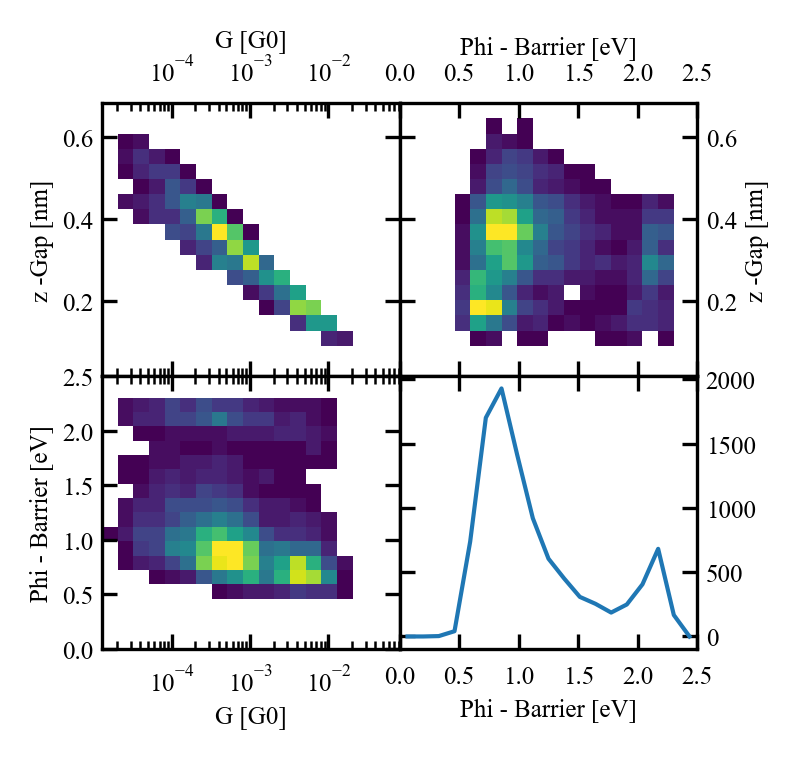

In [191]:
figsize = utils.cm2inch((6, 6))
dpi = 300

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(2, 2, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]

print(len(ax))

ax[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=True, labelbottom=False)
ax[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=True, labelbottom=False)
ax[2].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
ax[3].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=False, labelbottom=True)

ax[0].xaxis.set_label_position('top')
ax[1].xaxis.set_label_position('top')
ax[1].yaxis.set_label_position('right')
ax[3].yaxis.set_label_position('right')

# ax[0].scatter(sim_data_pull['G [G0]'], sim_data_pull['z -Gap [nm]'], s=1, alpha=0.5)

bins_G, _ = utils.calc_hist_1d_single(data=sim_data_pull['G [G0]'], xrange=(1e-5, 1e-1),
                                      xbins_num=20, log_scale=True, bin_mode='total')
bins_z, _ = utils.calc_hist_1d_single(data=sim_data_pull['z -Gap [nm]'], xrange=(0, 0.7),
                                      xbins_num=20, log_scale=False, bin_mode='total')
bins_Phi, hist_1d_Phi = utils.calc_hist_1d_single(data=sim_data_pull['Phi - Barrier [eV]'], xrange=(0, 2.5),
                                                  xbins_num=20, log_scale=False, bin_mode='total')

h0, xedges, yedges = np.histogram2d(sim_data_pull['G [G0]'], sim_data_pull['z -Gap [nm]'],
                                    bins=[bins_G, bins_z])
x_mesh0, y_mesh0 = np.meshgrid(xedges, yedges)
im0 = ax[0].pcolormesh(x_mesh0, y_mesh0, h0.T, cmap=my_cmap, vmin=-1)

ax[0].set_xlabel('G [G0]')
ax[0].set_xscale('log')
ax[0].set_ylabel('z -Gap [nm]')

ax[0].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[0].xaxis.set_minor_formatter(ticker.NullFormatter())

# ax[2].scatter(sim_data_pull['G [G0]'], sim_data_pull['Phi - Barrier [eV]'], s=1, alpha=0.5)

h2, xedges, yedges = np.histogram2d(sim_data_pull['G [G0]'], sim_data_pull['Phi - Barrier [eV]'],
                                    bins=[bins_G, bins_Phi])
x_mesh2, y_mesh2 = np.meshgrid(xedges, yedges)
im2 = ax[2].pcolormesh(x_mesh2, y_mesh2, h2.T, cmap=my_cmap, vmin=-1)

ax[2].set_xlabel('G [G0]')
ax[2].set_xscale('log')
ax[2].set_ylabel('Phi - Barrier [eV]')
ax[2].set_ylim(0, 2.5)

ax[2].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[2].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[2].xaxis.set_minor_formatter(ticker.NullFormatter())

# ax[1].scatter(sim_data_pull['Phi - Barrier [eV]'], sim_data_pull['z -Gap [nm]'], s=1, alpha=0.5)

h1, xedges, yedges = np.histogram2d(sim_data_pull['Phi - Barrier [eV]'], sim_data_pull['z -Gap [nm]'],
                                    bins=[bins_Phi, bins_z])
x_mesh1, y_mesh1 = np.meshgrid(xedges, yedges)
im1 = ax[1].pcolormesh(x_mesh1, y_mesh1, h1.T, cmap=my_cmap, vmin=-1)

ax[1].set_xlabel('Phi - Barrier [eV]')
ax[1].set_xlim(0, 2.5)
ax[1].set_xticks(np.arange(0, 2.51, 0.5))
ax[1].set_ylabel('z -Gap [nm]')

ax[3].plot(bins_Phi, hist_1d_Phi, lw=1)
ax[3].set_xlim(0, 2.5)
ax[3].set_xticks(np.arange(0, 2.51, 0.5))
ax[3].set_xlabel('Phi - Barrier [eV]')

4


Text(0.5, 0, 'Phi - Barrier [eV]')

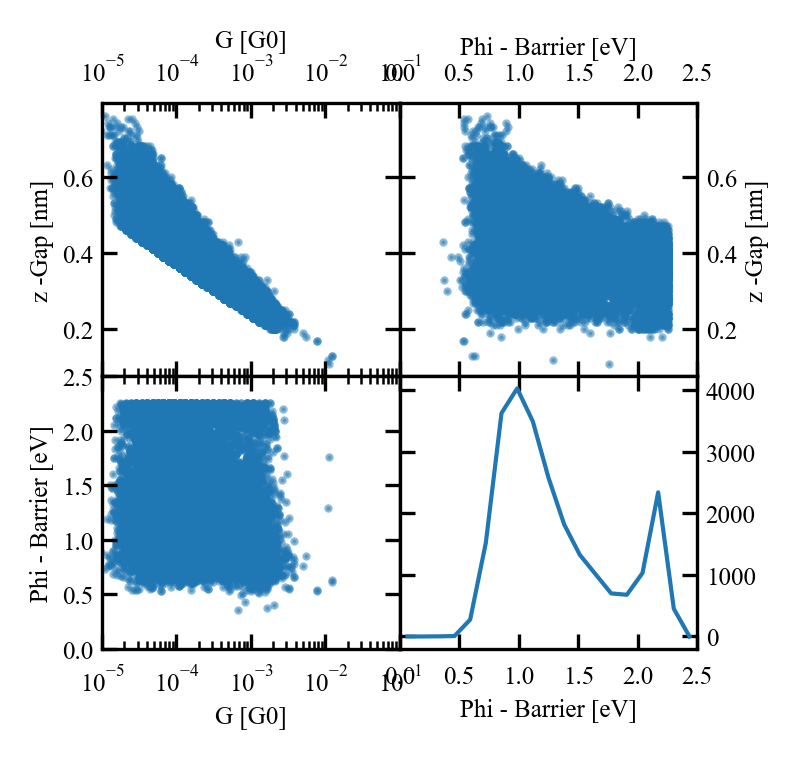

In [196]:
figsize = utils.cm2inch((6, 6))
dpi = 300

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(2, 2, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]

print(len(ax))

ax[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=True, labelbottom=False)
ax[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=True, labelbottom=False)
ax[2].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
ax[3].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=False, labelbottom=True)

ax[0].xaxis.set_label_position('top')
ax[1].xaxis.set_label_position('top')
ax[1].yaxis.set_label_position('right')
ax[3].yaxis.set_label_position('right')

ax[0].scatter(sim_data_push['G [G0]'], sim_data_push['z -Gap [nm]'], s=1, alpha=0.5)
ax[0].set_xlabel('G [G0]')
ax[0].set_xlim(1e-5, 1e-1)
ax[0].set_xscale('log')
ax[0].set_ylabel('z -Gap [nm]')

ax[0].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[0].xaxis.set_minor_formatter(ticker.NullFormatter())

ax[2].scatter(sim_data_push['G [G0]'], sim_data_push['Phi - Barrier [eV]'], s=1, alpha=0.5)
ax[2].set_xlabel('G [G0]')
ax[2].set_xlim(1e-5, 1e-1)
ax[2].set_xscale('log')
ax[2].set_ylabel('Phi - Barrier [eV]')
ax[2].set_ylim(0, 2.5)

ax[2].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[2].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[2].xaxis.set_minor_formatter(ticker.NullFormatter())

ax[1].scatter(sim_data_push['Phi - Barrier [eV]'], sim_data_push['z -Gap [nm]'], s=1, alpha=0.5)
ax[1].set_xlabel('Phi - Barrier [eV]')
ax[1].set_xlim(0, 2.5)
ax[1].set_xticks(np.arange(0, 2.51, 0.5))
ax[1].set_ylabel('z -Gap [nm]')
phi_bins, phi_hist1d = utils.calc_hist_1d_single(data=sim_data_push['Phi - Barrier [eV]'], xrange=(0, 2.5),
                                                 xbins_num=20, log_scale=False, bin_mode='total')

ax[3].plot(phi_bins, phi_hist1d, lw=1)
ax[3].set_xlim(0, 2.5)
ax[3].set_xticks(np.arange(0, 2.51, 0.5))
ax[3].set_xlabel('Phi - Barrier [eV]')

4


Text(0.5, 0, 'Phi - Barrier [eV]')

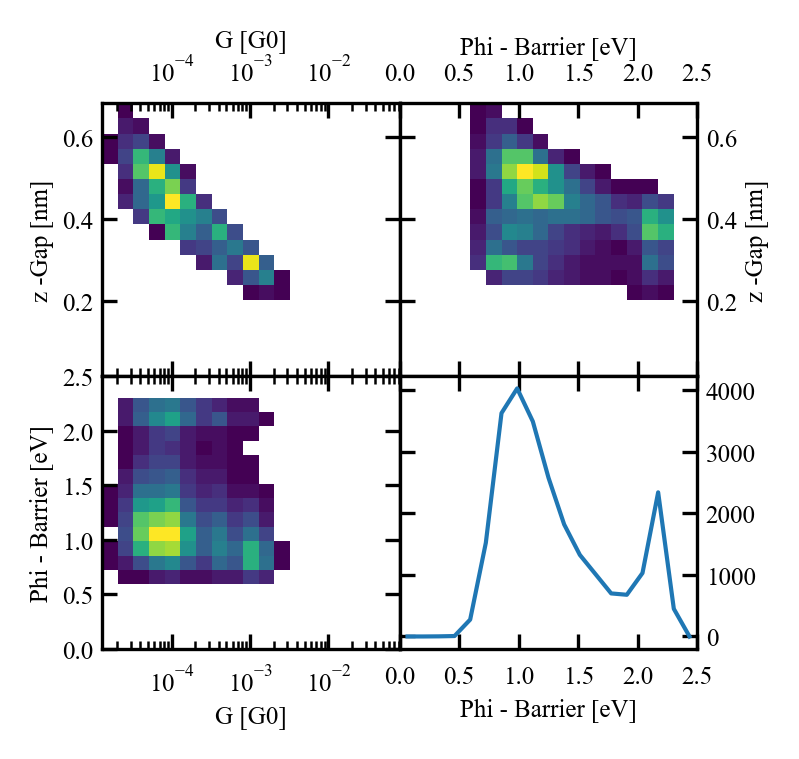

In [192]:
figsize = utils.cm2inch((6, 6))
dpi = 300

fig = plt.figure(figsize=figsize, dpi=dpi)
gs = plt.GridSpec(2, 2, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]

print(len(ax))

ax[0].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=True, labelbottom=False)
ax[1].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=True, labelbottom=False)
ax[2].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=True, labelright=False, labeltop=False, labelbottom=True)
ax[3].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                  labelleft=False, labelright=True, labeltop=False, labelbottom=True)

ax[0].xaxis.set_label_position('top')
ax[1].xaxis.set_label_position('top')
ax[1].yaxis.set_label_position('right')
ax[3].yaxis.set_label_position('right')

# ax[0].scatter(sim_data_push['G [G0]'], sim_data_push['z -Gap [nm]'], s=1, alpha=0.5)

bins_G, _ = utils.calc_hist_1d_single(data=sim_data_push['G [G0]'], xrange=(1e-5, 1e-1),
                                      xbins_num=20, log_scale=True, bin_mode='total')
bins_z, _ = utils.calc_hist_1d_single(data=sim_data_push['z -Gap [nm]'], xrange=(0, 0.7),
                                      xbins_num=20, log_scale=False, bin_mode='total')
bins_Phi, hist_1d_Phi = utils.calc_hist_1d_single(data=sim_data_push['Phi - Barrier [eV]'], xrange=(0, 2.5),
                                                  xbins_num=20, log_scale=False, bin_mode='total')

h0, xedges, yedges = np.histogram2d(sim_data_push['G [G0]'], sim_data_push['z -Gap [nm]'],
                                    bins=[bins_G, bins_z])
x_mesh0, y_mesh0 = np.meshgrid(xedges, yedges)
im0 = ax[0].pcolormesh(x_mesh0, y_mesh0, h0.T, cmap=my_cmap, vmin=-1)

ax[0].set_xlabel('G [G0]')
ax[0].set_xscale('log')
ax[0].set_ylabel('z -Gap [nm]')

ax[0].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[0].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[0].xaxis.set_minor_formatter(ticker.NullFormatter())

# ax[2].scatter(sim_data_push['G [G0]'], sim_data_push['Phi - Barrier [eV]'], s=1, alpha=0.5)

h2, xedges, yedges = np.histogram2d(sim_data_push['G [G0]'], sim_data_push['Phi - Barrier [eV]'],
                                    bins=[bins_G, bins_Phi])
x_mesh2, y_mesh2 = np.meshgrid(xedges, yedges)
im2 = ax[2].pcolormesh(x_mesh2, y_mesh2, h2.T, cmap=my_cmap, vmin=-1)

ax[2].set_xlabel('G [G0]')
ax[2].set_xscale('log')
ax[2].set_ylabel('Phi - Barrier [eV]')
ax[2].set_ylim(0, 2.5)

ax[2].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
ax[2].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
ax[2].xaxis.set_minor_formatter(ticker.NullFormatter())

# ax[1].scatter(sim_data_push['Phi - Barrier [eV]'], sim_data_push['z -Gap [nm]'], s=1, alpha=0.5)

h1, xedges, yedges = np.histogram2d(sim_data_push['Phi - Barrier [eV]'], sim_data_push['z -Gap [nm]'],
                                    bins=[bins_Phi, bins_z])
x_mesh1, y_mesh1 = np.meshgrid(xedges, yedges)
im1 = ax[1].pcolormesh(x_mesh1, y_mesh1, h1.T, cmap=my_cmap, vmin=-1)

ax[1].set_xlabel('Phi - Barrier [eV]')
ax[1].set_xlim(0, 2.5)
ax[1].set_xticks(np.arange(0, 2.51, 0.5))
ax[1].set_ylabel('z -Gap [nm]')

ax[3].plot(bins_Phi, hist_1d_Phi, lw=1)
ax[3].set_xlim(0, 2.5)
ax[3].set_xticks(np.arange(0, 2.51, 0.5))
ax[3].set_xlabel('Phi - Barrier [eV]')